In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle


path = os.getcwd().split(os.sep + 'network')[0]
if path not in sys.path:
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.data as data

    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

In [2]:
def plot_0():

    fig, ax = plt.subplots(2,2, figsize=(24,20))
    ax[0,0].plot(aln.t, aln.rates_exc[0,:], lw=1, c='red', label='Node 0 exc')
    ax[0,1].plot(aln.t, aln.rates_inh[0,:], lw=1, c='blue', label='Node 0 inh')
    ax[1,0].plot(aln.t, aln.rates_exc[1,:], lw=1, c='red', label='Node 1 exc')
    ax[1,1].plot(aln.t, aln.rates_inh[1,:], lw=1, c='blue', label='Node 1 inh')


    for i in range(2):
        for j in range(2):
            ax[i,j].set_xlabel("t [ms]")
            ax[i,j].set_ylabel("Rate [Hz]")
            ax[i,j].set_xlim(0, aln.t[-1])
            
    plt.show()


In [3]:
def plot(control0, state0, target=None):

    fig, ax = plt.subplots(4,2, figsize=(12,14))
    
    print(control0.shape[2], control0.shape[2] * aln.params.dt)
    
    t_array = np.arange(0., round(control0.shape[2] * aln.params.dt, 1), aln.params.dt)
    print(t_array.shape, state0.shape)

    ax[0,0].plot(t_array, state0[0,0,:], lw=1, c='red', label='Node 0 exc')
    ax[0,1].plot(t_array, state0[0,1,:], lw=1, c='blue', label='Node 0 inh')
    ax[1,0].plot(t_array, state0[1,0,:], lw=1, c='red', label='Node 1 exc')
    ax[1,1].plot(t_array, state0[1,1,:], lw=1, c='blue', label='Node 1 inh')

    if type(target) != type(None):
        ax[0,0].plot(t_array, target[0,0,:], linestyle='--', c='red')
        ax[0,1].plot(t_array, target[0,1,:], linestyle='--', c='blue')
        ax[1,0].plot(t_array, target[1,0,:], linestyle='--', c='red')
        ax[1,1].plot(t_array, target[1,1,:], linestyle='--', c='blue')

    ax[2,0].plot(t_array, control0[0,0,:], c='red', label='Node 0 exc')
    ax[2,1].plot(t_array, control0[0,1,:], c='blue', label='Node 0 inh')
    ax[3,0].plot(t_array, control0[1,0,:], c='red', label='Node 1 exc')
    ax[3,1].plot(t_array, control0[1,1,:], c='blue', label='Node 1 inh')

    for i in range(2):
        for j in range(2):
            ax[i,j].set_xlabel("t [ms]")
            ax[i,j].set_ylabel("Rate [Hz]")
            ax[i,j].set_xlim(0, aln.params.duration)

    for i in range(2,4):
        for j in range(2):
            ax[i,j].set_xlabel("t [ms]")
            ax[i,j].set_ylabel("Control [nA]")
            ax[i,j].set_xlim(0, aln.params.duration)

    plt.show()
    
def setinit(initvars, N):
    state_vars = aln.state_vars
    init_vars = aln.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                for n in range(N):
                    if aln.params[init_vars[iv]].ndim == 1:
                        aln.params[init_vars[iv]][n] = initvars[n,sv]
                    else:
                        aln.params[init_vars[iv]][n,:] = initvars[n,sv]

In [4]:
def initmodel(mue, mui, cmat, dmat):
    aln = ALNModel(Cmat = cmat, Dmat = dmat)
    aln.params.Dmat = dmat
    
    N = aln.params.N
    aln.params.sigma_ou = 0.
    aln.params.a = 0.
    aln.params.b = 0.

    aln.params.ext_exc_current = 0.
    aln.params.ext_inh_current = 0.

    aln.params.mue_ext_mean = mue * 5.
    aln.params.mui_ext_mean = mui * 5.
    
    aln.params.de = 0.
    aln.params.di = 0.
    
    return aln

In [5]:
cmat = 1. * np.array( [[0., 0.], [1., 0.]] )
dmat = 0. * np.array( [[1., 1.], [1., 1.]] )
aln = initmodel(0., 0., cmat, dmat)
N = aln.params.N

tol = 1e-10
start_step = 10.

max_cntrl = [5., 5., 100., 100., 100., 100.]
min_cntrl = [-5., -5., 0., 0., 0., 0.]

dur_pre = 10.
dur_post = 10.
trans_time = 0.9
n_pre = int(dur_pre / aln.params.dt)
n_post = int(dur_post / aln.params.dt)

c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

In [6]:
state_vars = aln.state_vars
init_vars = aln.init_vars

In [12]:
mu_e = np.arange(0.0,0.8,0.02)
mu_i = np.arange(0.0,0.8,0.02)
state = np.zeros (( len(mu_e), len(mu_i) ))
# low 0 - black, high 1 - red, bi 2 - green, osc 3 - yellow, bi osc - orange, low/ osc -5 - purple, misc -1 - gray
x_, y_, c_ = [], [], []

for i in range(len(mu_i)):
    for e in range(len(mu_e)):                
        print('-----', e, i)
        aln = initmodel(mu_e[e], mu_i[i], cmat, dmat)
        
        x_.append(mu_e[e])
        y_.append(mu_i[i])
        
        aln.params.duration = 2000.
        control0 = aln.getZeroControl()
        control0[:,0,:2000] = -2.
        control0[:,0,10000:12000] = 2.
        aln.run(control=control0)
        #plot_0()
        
        if ( np.std(aln.rates_exc[0,-1000:]) > 1. and np.std(aln.rates_exc[0,9000:10000]) > 1.
            and np.std(aln.rates_exc[1,-1000:]) > 1. and np.std(aln.rates_exc[1,9000:10000]) > 1. ):
            print("monostable oscillations")
            state[e,i] = 3
            c_.append('yellow')
        elif ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,9999]) > 1.
            and np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,9999]) > 1.
            and np.abs(aln.rates_inh[0,-1] - aln.rates_inh[0,9999]) > 1.
            and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,9999]) > 1. ):
            
            if ( ( np.std(aln.rates_exc[0,-1000:]) > 1. or np.std(aln.rates_exc[0,9000:10000]) > 1. )
                and ( np.std(aln.rates_exc[1,-1000:]) > 1. or np.std(aln.rates_exc[1,9000:10000]) > 1. ) ):
                print("bi oscillations")
                state[e,i] = 4
                c_.append('orange')
            elif ( np.std(aln.rates_exc[0,-1000:]) < 1. and np.std(aln.rates_exc[0,9000:10000]) < 1. 
                and np.std(aln.rates_exc[1,-1000:]) < 1. and np.std(aln.rates_exc[1,9000:10000]) < 1. ):
                print("bistable ")
                state[e,i] = 2
                c_.append('green')
            else:
                c_.append('gray')
        elif ( np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,9999]) < 1.
            and np.abs(aln.rates_exc[1,-1] - aln.rates_exc[1,9999]) < 1.
            and np.abs(aln.rates_exc[0,-1] - aln.rates_exc[0,9999]) < 1.
            and np.abs(aln.rates_inh[1,-1] - aln.rates_inh[1,9999]) < 1. ):
            print("monostable")
            if aln.rates_exc[0,-1] < 1.:
                print("low state")
                state[e,i] = 0
                c_.append('black')
            else:
                print("high state")
                state[e,i] = 1
                c_.append('red')
        else:
            state[e,i] = -1
            c_.append('gray')

----- 0 0
monostable
low state
----- 1 0
----- 2 0
monostable oscillations
----- 3 0
monostable oscillations
----- 4 0
monostable oscillations
----- 5 0
monostable oscillations
----- 6 0
monostable oscillations
----- 7 0
monostable oscillations
----- 8 0
monostable oscillations
----- 9 0
----- 10 0
monostable
high state
----- 11 0
monostable
high state
----- 12 0
monostable
high state
----- 13 0
monostable
high state
----- 14 0
monostable
high state
----- 15 0
monostable
high state
----- 16 0
monostable
high state
----- 17 0
monostable
high state
----- 18 0
monostable
high state
----- 19 0
monostable
high state
----- 20 0
monostable
high state
----- 21 0
monostable
high state
----- 22 0
monostable
high state
----- 23 0
monostable
high state
----- 24 0
monostable
high state
----- 25 0
monostable
high state
----- 26 0
monostable
high state
----- 27 0
monostable
high state
----- 28 0
monostable
high state
----- 29 0
monostable
high state
----- 30 0
monostable
high state
----- 31 0
monosta

monostable
high state
----- 15 6
monostable
high state
----- 16 6
monostable
high state
----- 17 6
monostable
high state
----- 18 6
monostable
high state
----- 19 6
monostable
high state
----- 20 6
monostable
high state
----- 21 6
monostable
high state
----- 22 6
monostable
high state
----- 23 6
monostable
high state
----- 24 6
monostable
high state
----- 25 6
monostable
high state
----- 26 6
monostable
high state
----- 27 6
monostable
high state
----- 28 6
monostable
high state
----- 29 6
monostable
high state
----- 30 6
monostable
high state
----- 31 6
monostable
high state
----- 32 6
monostable
high state
----- 33 6
monostable
high state
----- 34 6
monostable
high state
----- 35 6
monostable
high state
----- 36 6
monostable
high state
----- 37 6
monostable
high state
----- 38 6
monostable
high state
----- 39 6
monostable
high state
----- 0 7
monostable
low state
----- 1 7
monostable
low state
----- 2 7
monostable
low state
----- 3 7
monostable
low state
----- 4 7
monostable
low stat

monostable
high state
----- 27 12
monostable
high state
----- 28 12
monostable
high state
----- 29 12
monostable
high state
----- 30 12
monostable
high state
----- 31 12
monostable
high state
----- 32 12
monostable
high state
----- 33 12
monostable
high state
----- 34 12
monostable
high state
----- 35 12
monostable
high state
----- 36 12
monostable
high state
----- 37 12
monostable
high state
----- 38 12
monostable
high state
----- 39 12
monostable
high state
----- 0 13
monostable
low state
----- 1 13
monostable
low state
----- 2 13
monostable
low state
----- 3 13
monostable
low state
----- 4 13
monostable
low state
----- 5 13
monostable
low state
----- 6 13
monostable
low state
----- 7 13
monostable
low state
----- 8 13
monostable
low state
----- 9 13
monostable
low state
----- 10 13
monostable
low state
----- 11 13
monostable
low state
----- 12 13
monostable
low state
----- 13 13
monostable
low state
----- 14 13
monostable
low state
----- 15 13
monostable
low state
----- 16 13
monost

monostable
high state
----- 0 19
monostable
low state
----- 1 19
monostable
low state
----- 2 19
monostable
low state
----- 3 19
monostable
low state
----- 4 19
monostable
low state
----- 5 19
monostable
low state
----- 6 19
monostable
low state
----- 7 19
monostable
low state
----- 8 19
monostable
low state
----- 9 19
monostable
low state
----- 10 19
monostable
low state
----- 11 19
monostable
low state
----- 12 19
monostable
low state
----- 13 19
monostable
low state
----- 14 19
monostable
low state
----- 15 19
monostable
low state
----- 16 19
monostable
low state
----- 17 19
monostable
low state
----- 18 19
monostable
low state
----- 19 19
monostable
low state
----- 20 19
bistable 
----- 21 19
bistable 
----- 22 19
bistable 
----- 23 19
----- 24 19
monostable
high state
----- 25 19
monostable
high state
----- 26 19
monostable
high state
----- 27 19
monostable
high state
----- 28 19
monostable
high state
----- 29 19
monostable
high state
----- 30 19
monostable
high state
----- 31 19


bistable 
----- 21 25
bistable 
----- 22 25
bistable 
----- 23 25
bistable 
----- 24 25
bistable 
----- 25 25
bistable 
----- 26 25
bistable 
----- 27 25
bistable 
----- 28 25
monostable
high state
----- 29 25
monostable
high state
----- 30 25
monostable
high state
----- 31 25
monostable
high state
----- 32 25
monostable
high state
----- 33 25
monostable
high state
----- 34 25
monostable
high state
----- 35 25
monostable
high state
----- 36 25
monostable
high state
----- 37 25
monostable
high state
----- 38 25
monostable
high state
----- 39 25
monostable
high state
----- 0 26
monostable
low state
----- 1 26
monostable
low state
----- 2 26
monostable
low state
----- 3 26
monostable
low state
----- 4 26
monostable
low state
----- 5 26
monostable
low state
----- 6 26
monostable
low state
----- 7 26
monostable
low state
----- 8 26
monostable
low state
----- 9 26
monostable
low state
----- 10 26
monostable
low state
----- 11 26
monostable
low state
----- 12 26
monostable
low state
----- 13 

monostable
low state
----- 9 32
monostable
low state
----- 10 32
monostable
low state
----- 11 32
monostable
low state
----- 12 32
monostable
low state
----- 13 32
monostable
low state
----- 14 32
monostable
low state
----- 15 32
monostable
low state
----- 16 32
monostable
low state
----- 17 32
monostable
low state
----- 18 32
monostable
low state
----- 19 32
monostable
low state
----- 20 32
monostable
low state
----- 21 32
bistable 
----- 22 32
bistable 
----- 23 32
bistable 
----- 24 32
bistable 
----- 25 32
bistable 
----- 26 32
bistable 
----- 27 32
bistable 
----- 28 32
bistable 
----- 29 32
bistable 
----- 30 32
monostable
high state
----- 31 32
monostable
high state
----- 32 32
monostable
high state
----- 33 32
monostable
high state
----- 34 32
monostable
high state
----- 35 32
monostable
high state
----- 36 32
monostable
high state
----- 37 32
monostable
high state
----- 38 32
monostable
high state
----- 39 32
monostable
high state
----- 0 33
monostable
low state
----- 1 33
mon

monostable
low state
----- 4 39
monostable
low state
----- 5 39
monostable
low state
----- 6 39
monostable
low state
----- 7 39
monostable
low state
----- 8 39
monostable
low state
----- 9 39
monostable
low state
----- 10 39
monostable
low state
----- 11 39
monostable
low state
----- 12 39
monostable
low state
----- 13 39
monostable
low state
----- 14 39
monostable
low state
----- 15 39
monostable
low state
----- 16 39
monostable
low state
----- 17 39
monostable
low state
----- 18 39
monostable
low state
----- 19 39
monostable
low state
----- 20 39
monostable
low state
----- 21 39
bistable 
----- 22 39
bistable 
----- 23 39
bistable 
----- 24 39
bistable 
----- 25 39
bistable 
----- 26 39
bistable 
----- 27 39
bistable 
----- 28 39
bistable 
----- 29 39
bistable 
----- 30 39
bistable 
----- 31 39
monostable
high state
----- 32 39
monostable
high state
----- 33 39
monostable
high state
----- 34 39
monostable
high state
----- 35 39
monostable
high state
----- 36 39
monostable
high state


In [75]:
s_ = []
l_ = []
for i in range(len(x_)):
    if c_[i] in ['black', 'red', 'yellow', 'green']:
        s_.append(30.)
    else:
        s_.append(80.)

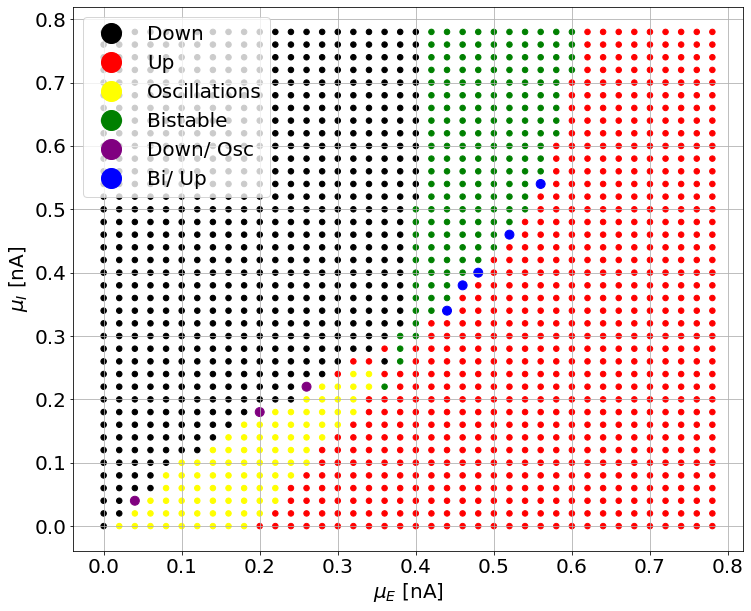

In [108]:
fig, ax = plt.subplots(figsize=(12,10))
scatter = ax.scatter(x_, y_, c=c_, s=s_)

down = plt.Line2D([-1], [-1], marker='o', linestyle='', color='black', markersize=20)
up = plt.Line2D([-1], [-1], marker='o', linestyle='', color='red', markersize=20)
osc = plt.Line2D([-1], [-1], marker='o', linestyle='', color='yellow', markersize=20)
bi = plt.Line2D([-1], [-1], marker='o', linestyle='', color='green', markersize=20)
low_osc = plt.Line2D([-1], [-1], marker='o', linestyle='', color='purple', markersize=20)
bi_up = plt.Line2D([-1], [-1], marker='o', linestyle='', color='blue', markersize=20)
down_bi = plt.Line2D([-1], [-1], marker='o', linestyle='', color='orange', markersize=20)


plt.legend([down, up, osc, bi, low_osc, bi_up, down_bi],['Down', 'Up', 'Oscillations', 'Bistable', 'Down/ Osc', 'Bi/ Up'] ,
           numpoints=1, loc='upper left', ncol=1, fontsize=20)

ax.set_xlabel(r'$\mu_E$ [nA]')
ax.set_ylabel(r'$\mu_I$ [nA]')#, alpha=0.3,cmap='viridis')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    
plt.show()

----- 702 0.44 0.34


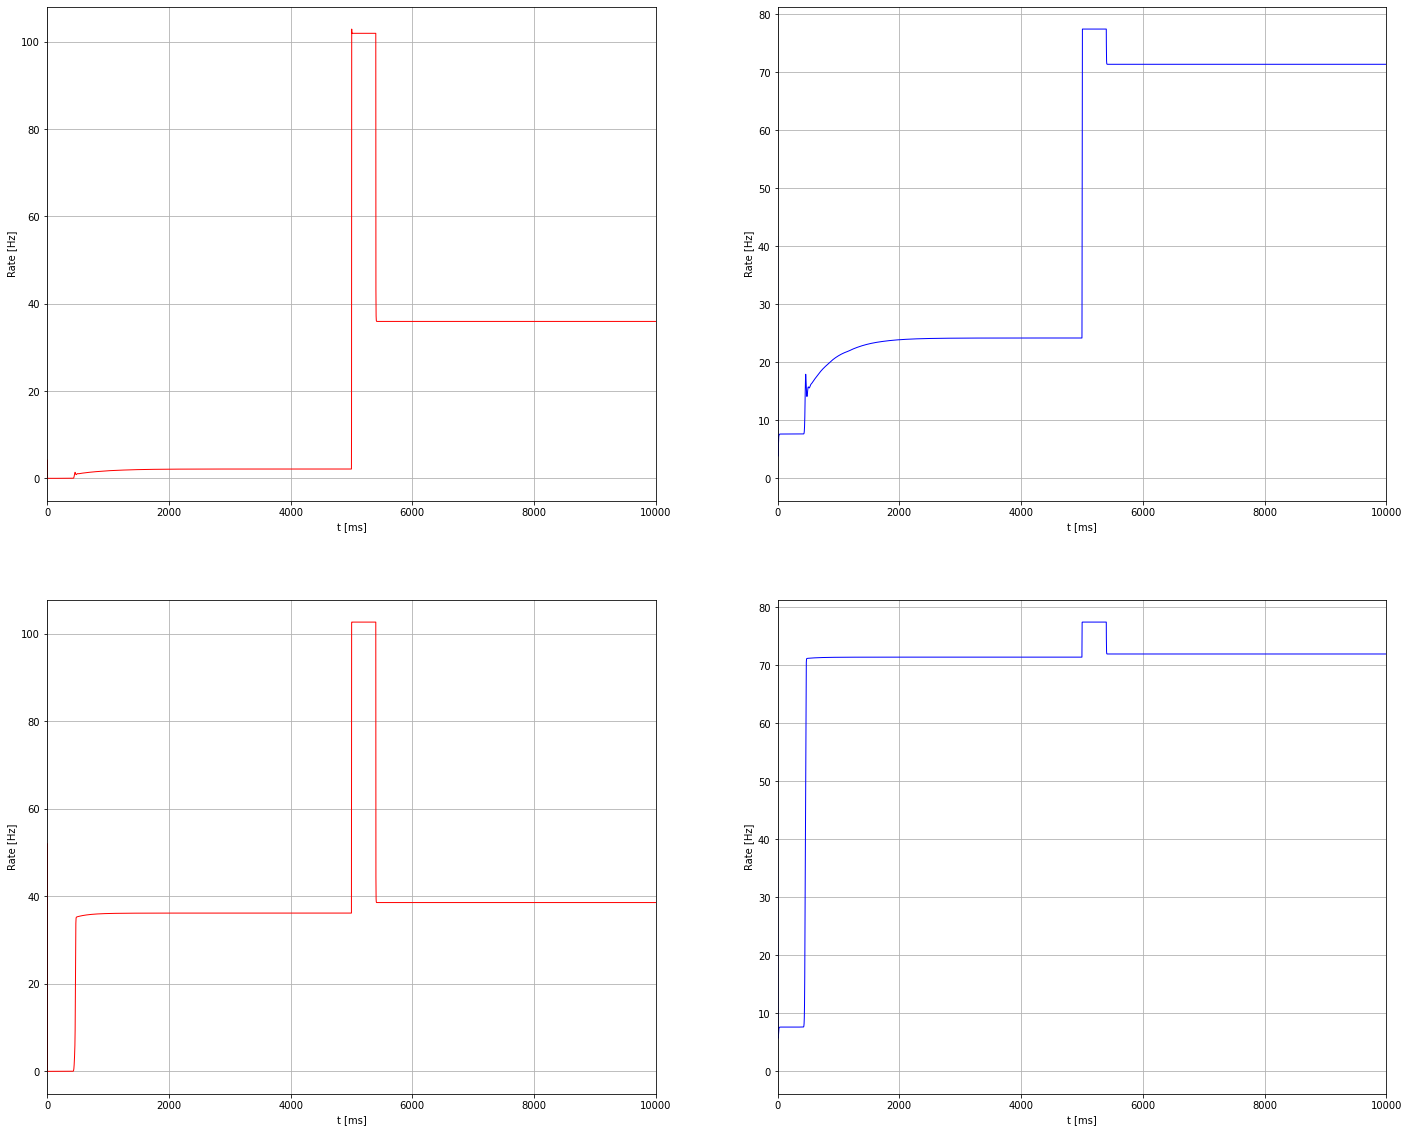

----- 783 0.46 0.38


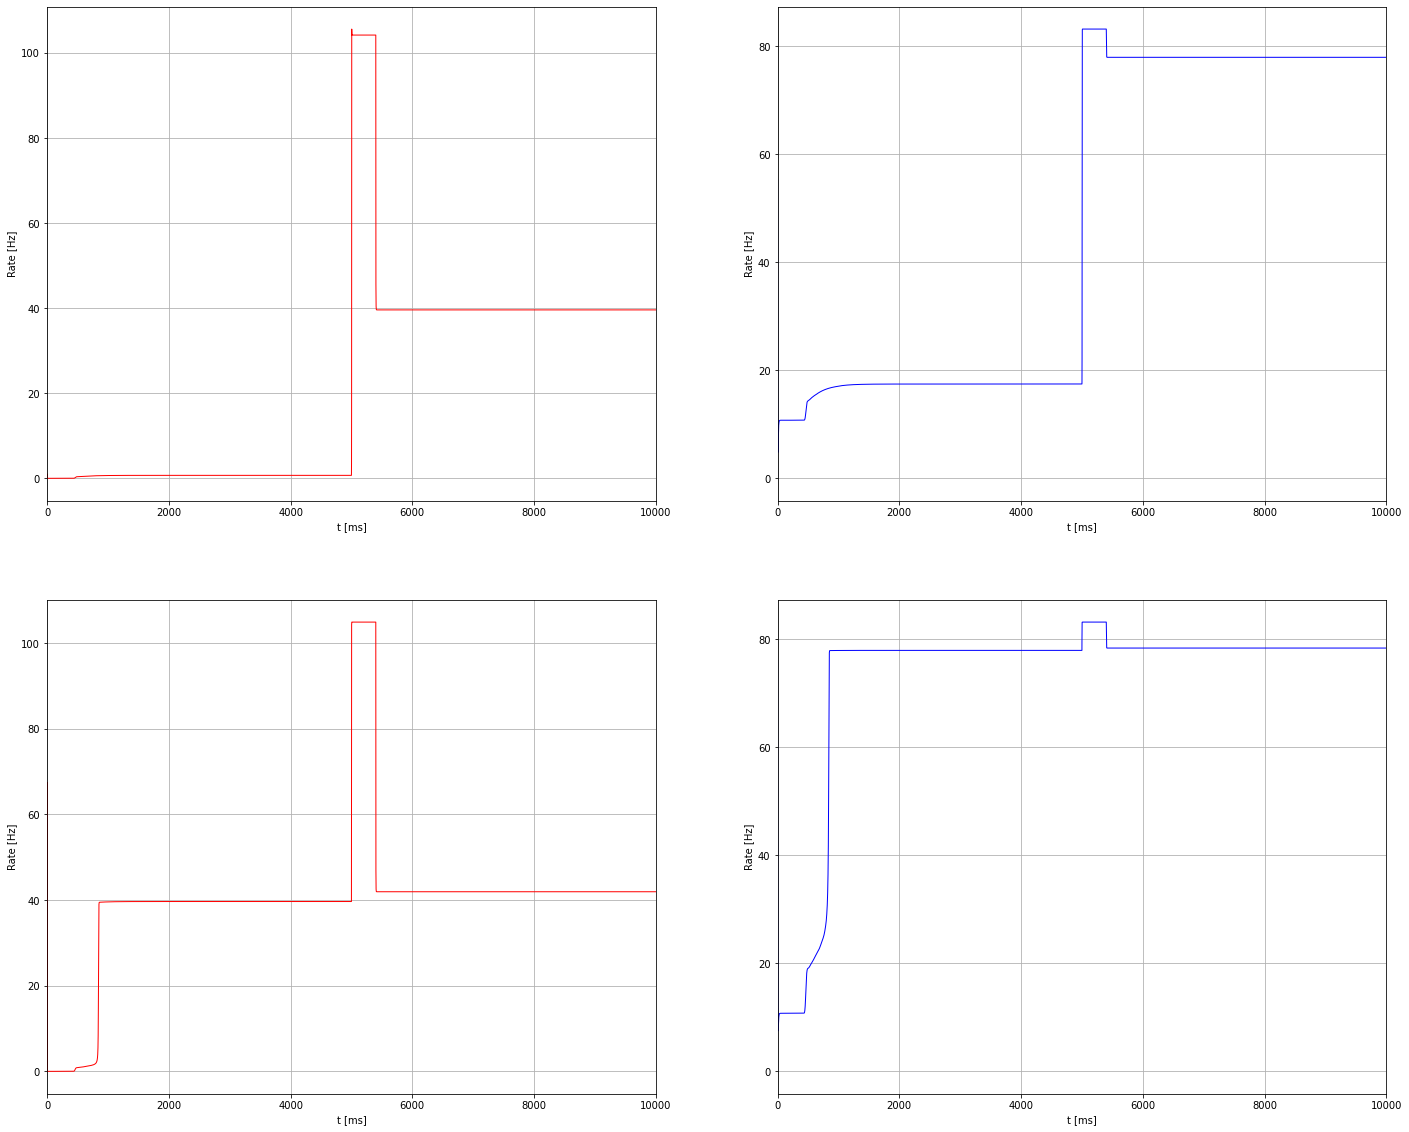

----- 824 0.48 0.4


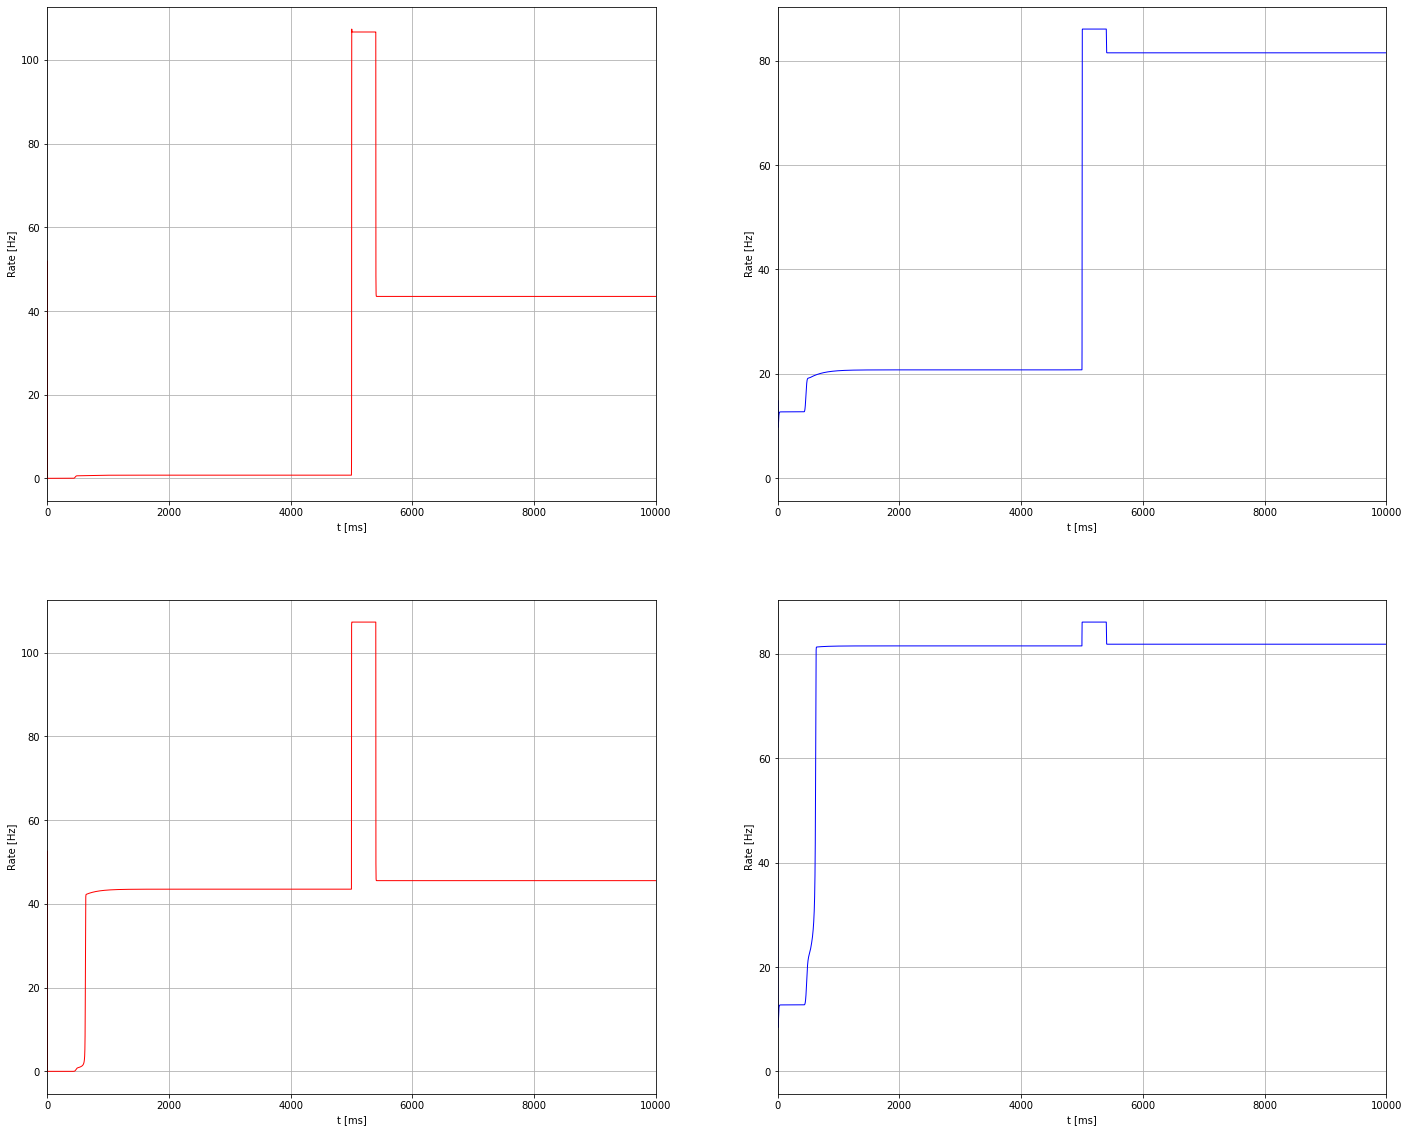

----- 946 0.52 0.46


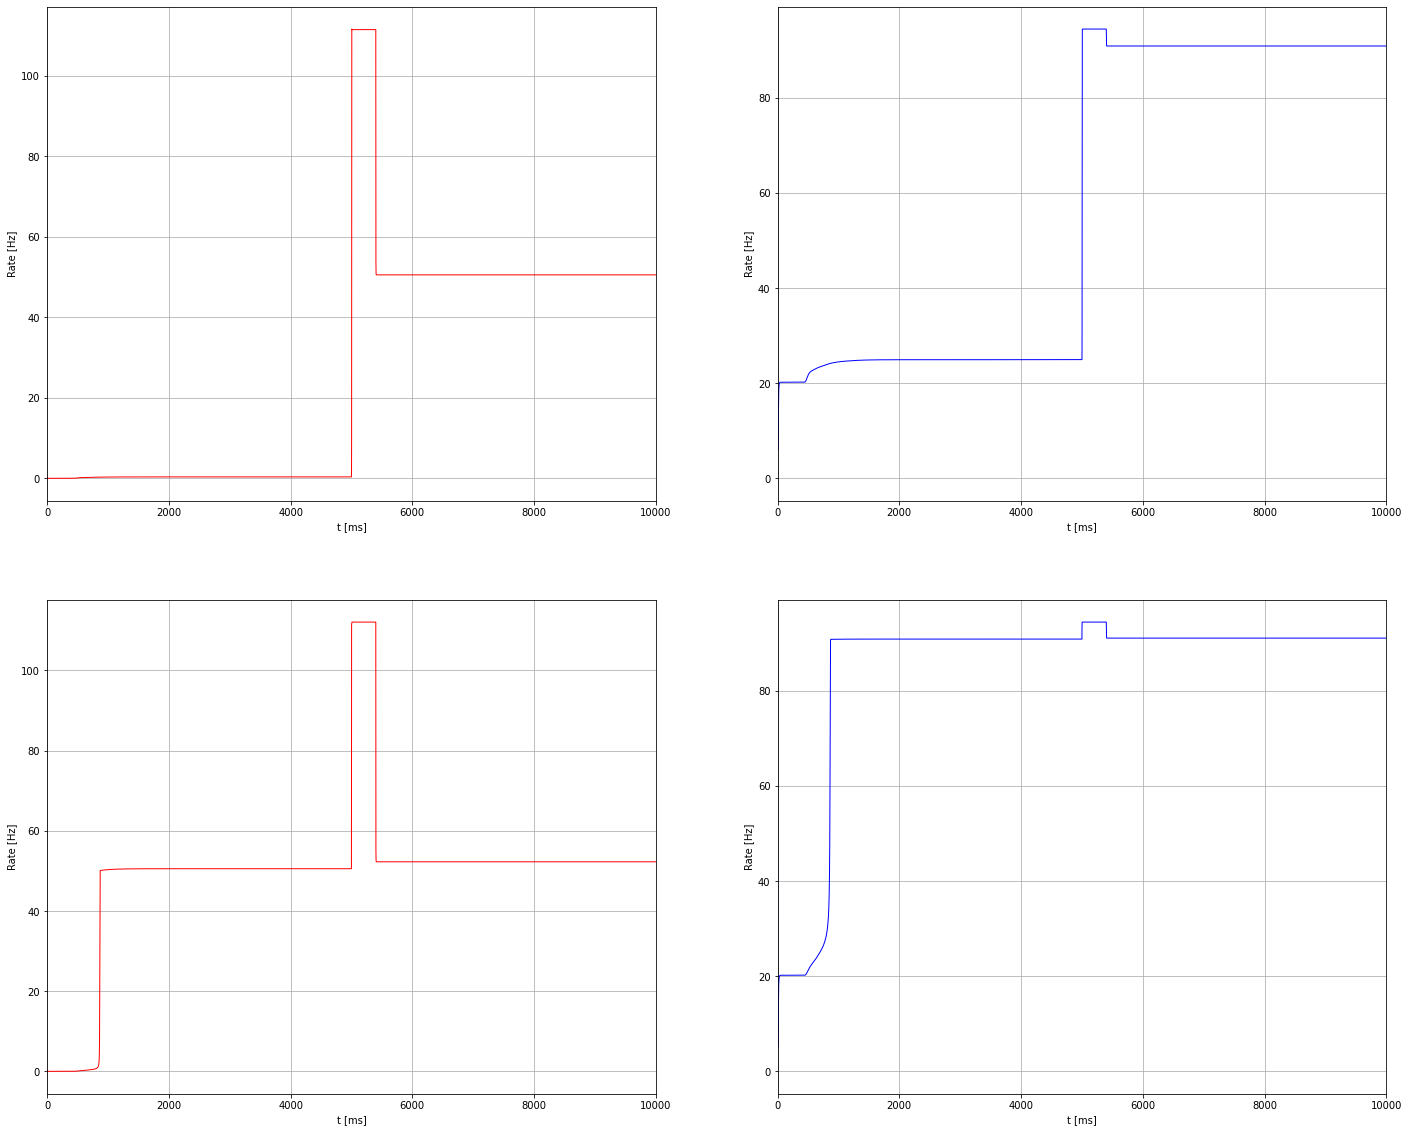

----- 1108 0.56 0.54


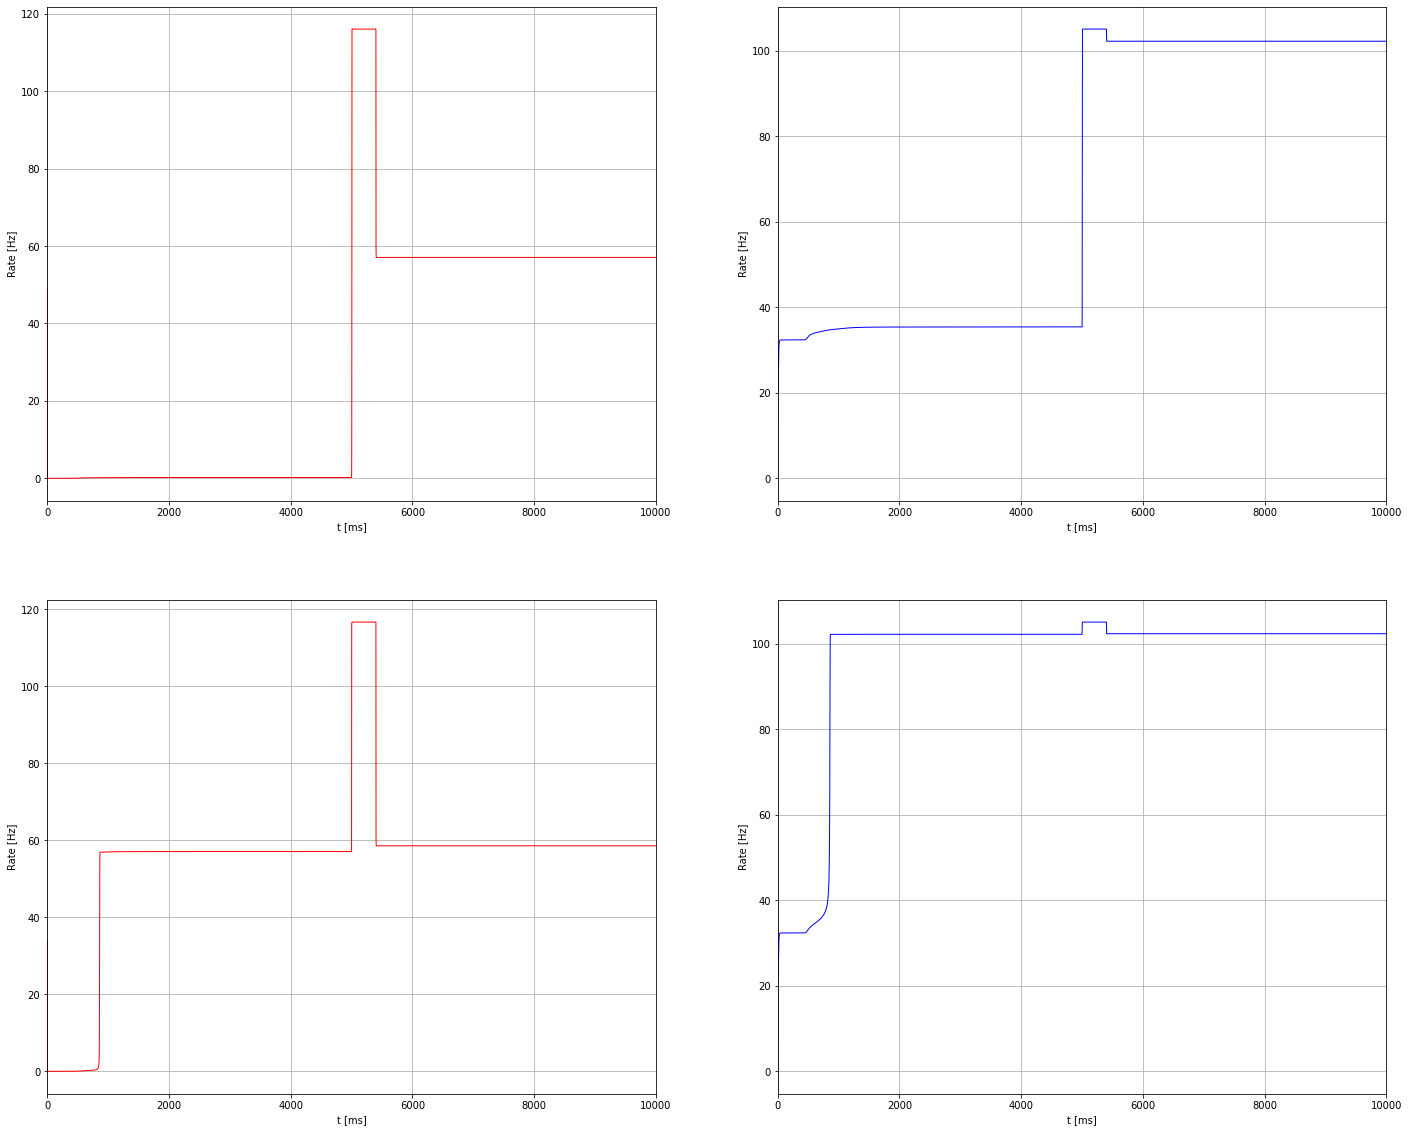

In [69]:


for i in range(len(x_)):
        
    if c_[i] in ['blue']:
        print('-----', i, x_[i], y_[i])
        aln = initmodel(x_[i], y_[i], cmat, dmat)

        aln.params.duration = 10 * 1000.
        aln.params.dt = 0.1
        
        t_ = int(round( 200. / aln.params.dt, 1) )
        t1 = int( round( aln.params.duration /aln.params.dt / 2., 1) )
        t0 = int( t1 - t_ )
        
        control0 = aln.getZeroControl()
        control0[:,0,:int(2*t_)] = -2.
        control0[:,0,t1:int(t1 + 2.*t_)] = 2.
        aln.run(control=control0)
        
        plot_0()
        
        """
        fig, ax = plt.subplots(2,4, figsize=(24,20))
        ax[0,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[0,t0:int(t0+t_)], lw=1, c='red', label='Node 0 exc')
        ax[1,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[1,t0:int(t0+t_)], lw=1, c='red', label='Node 0 exc')
        ax[0,1].plot(aln.t[-t_:], aln.rates_exc[0,-t_:], lw=1, c='red', label='Node 0 exc')
        ax[1,1].plot(aln.t[-t_:], aln.rates_exc[1,-t_:], lw=1, c='red', label='Node 0 exc')
        
        ax[0,2].plot(aln.t[t0:t0+t_], aln.rates_inh[0,t0:t0+t_], lw=1, c='red', label='Node 0 exc')
        ax[1,2].plot(aln.t[t0:t0+t_], aln.rates_inh[1,t0:t0+t_], lw=1, c='red', label='Node 0 exc')
        ax[0,3].plot(aln.t[-t_:], aln.rates_inh[0,-t_:], lw=1, c='red', label='Node 0 exc')
        ax[1,3].plot(aln.t[-t_:], aln.rates_inh[1,-t_:], lw=1, c='red', label='Node 0 exc')
        
        
        plt.show()
        """

In [68]:
# low 0 - black
# high 1 - red
#bi 2 - green
#osc 3 - yellow
#bi osc 4 - orange
#low/ osc 5 - purple
#bi/high 6 - blue
#misc -1 - gray
for i in [1, 9, 50, 91, 164, 205, 288, 329, 371, 376, 454]:
    c_[i] = 'yellow'
for i in [82, 370, 453]:
    c_[i] = 'purple'
for i in [538, 659]:
    c_[i] = 'black'
for i in [661, 702, 783, 824, 946, 1108]:
    c_[i] = 'blue'
for i in [661,1229,1430]:
    c_[i] = 'red'

----- 0 0


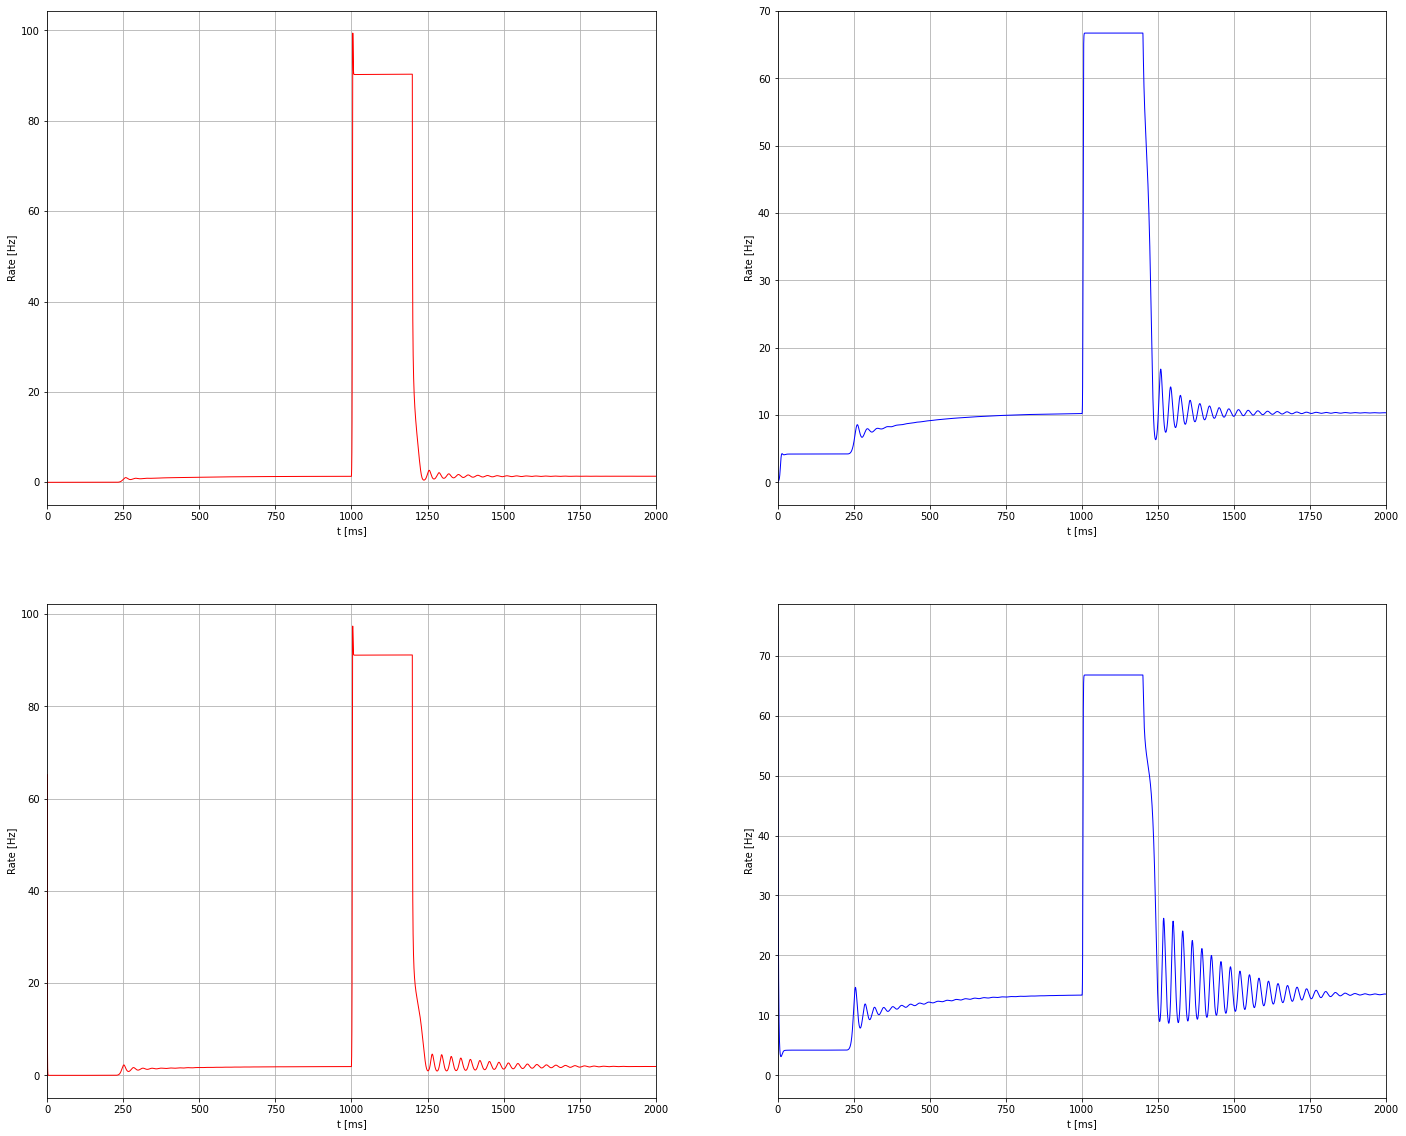

----- 1 0


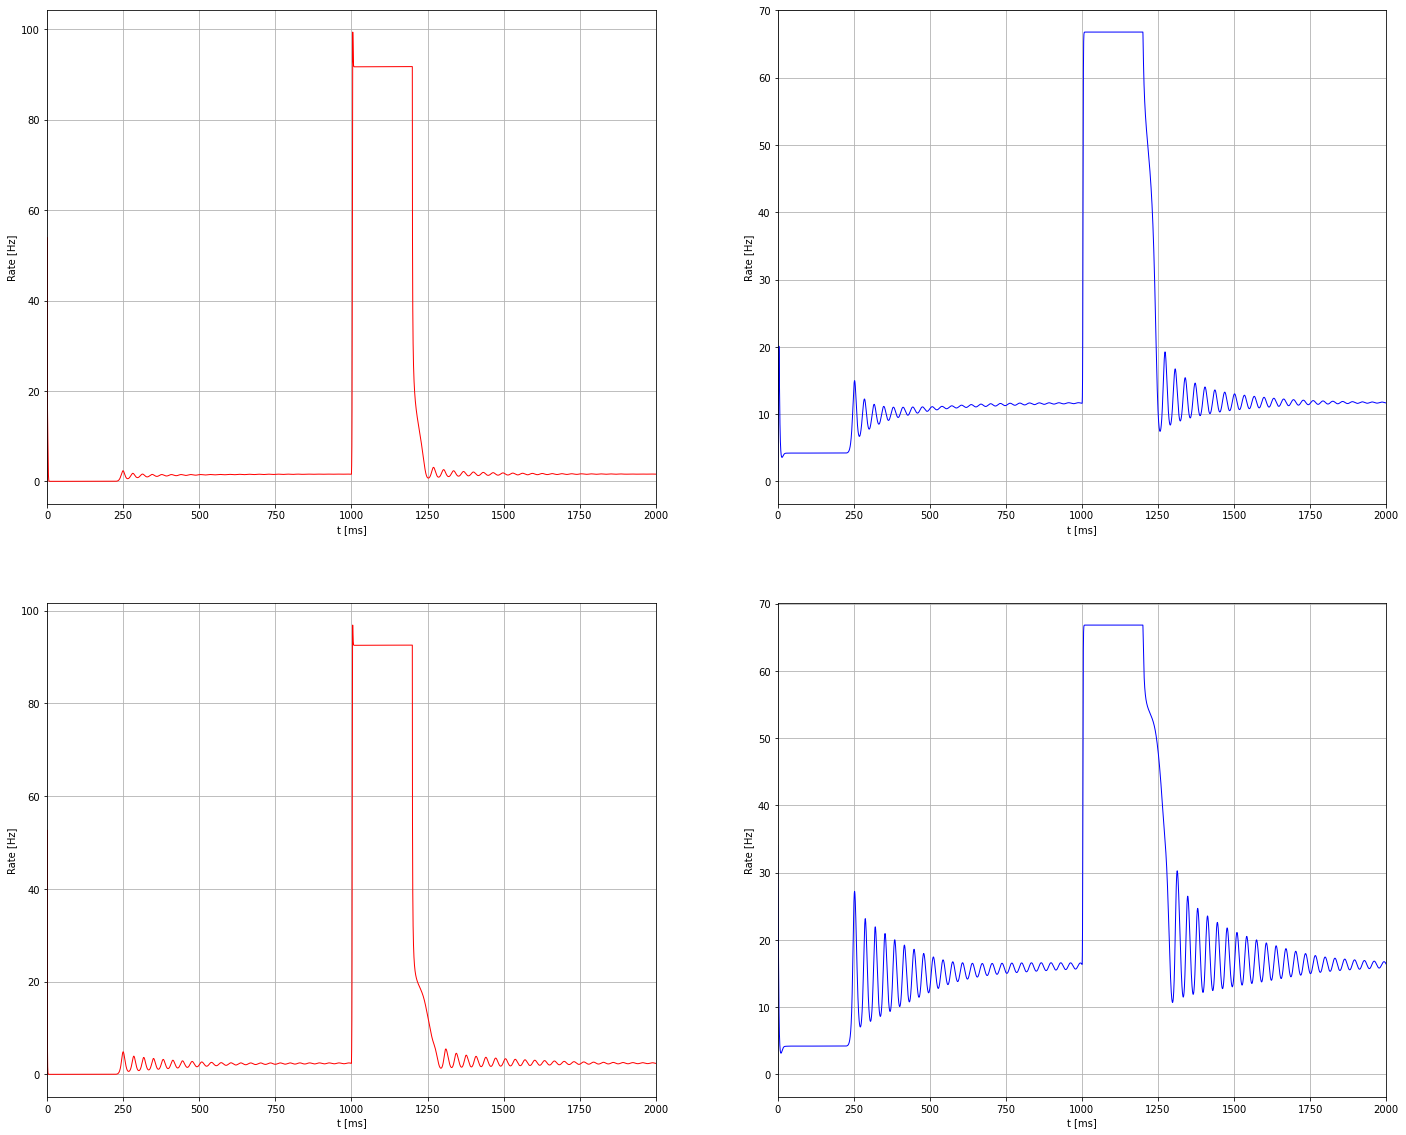

----- 2 0


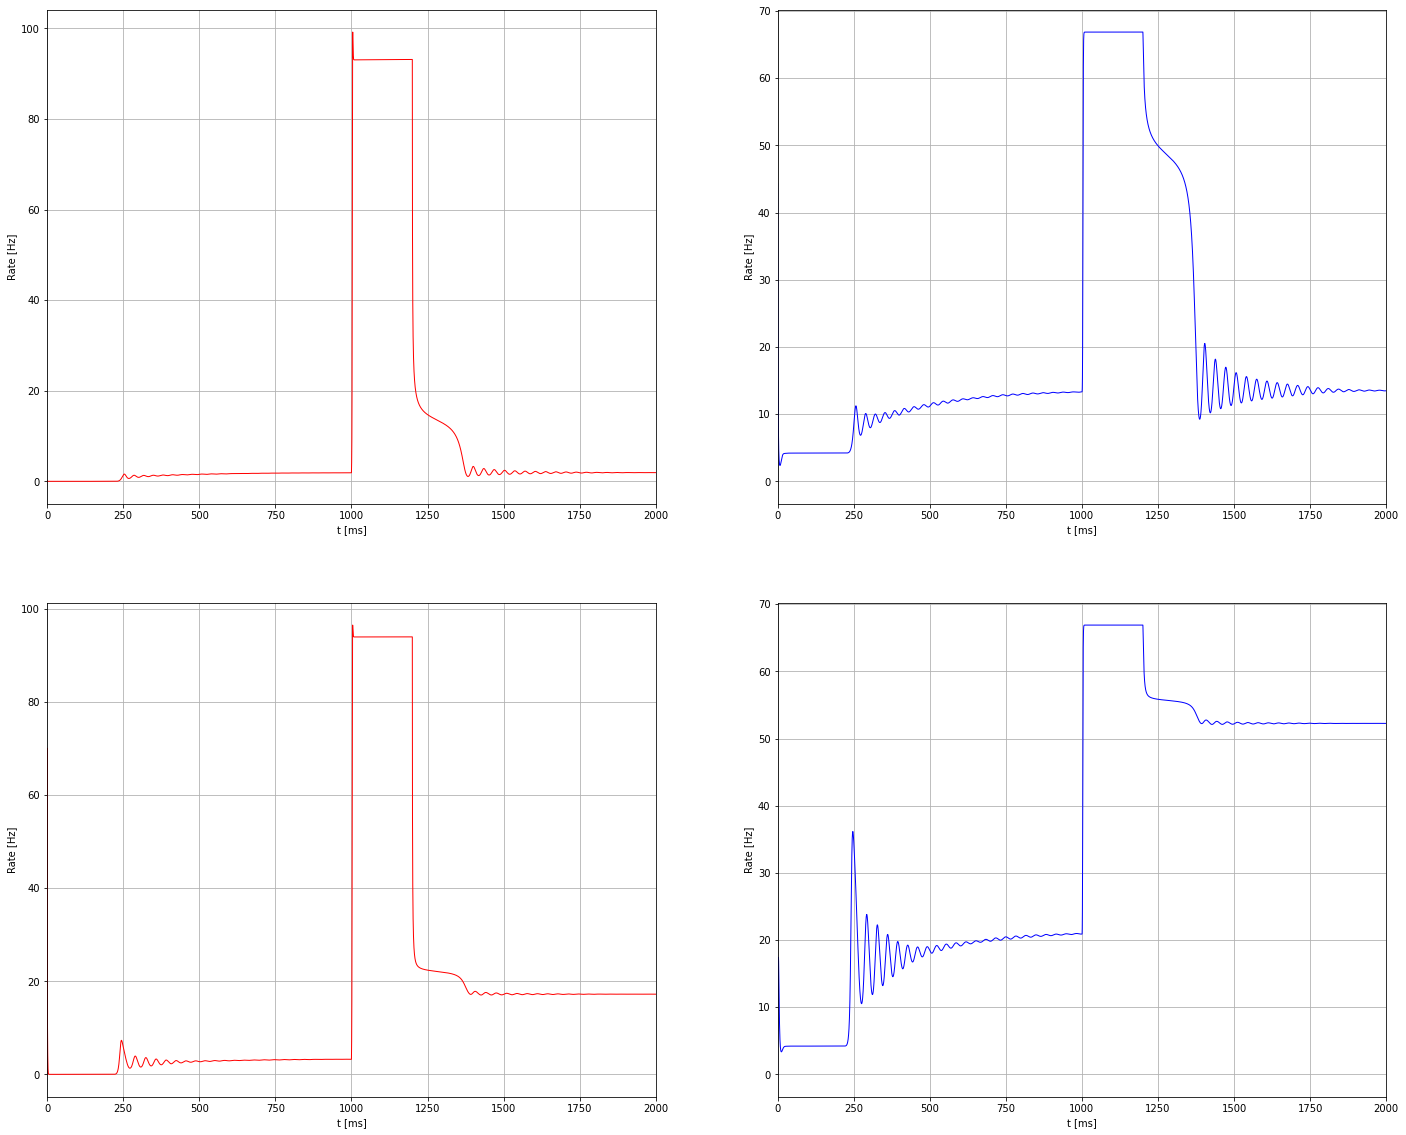

----- 3 0


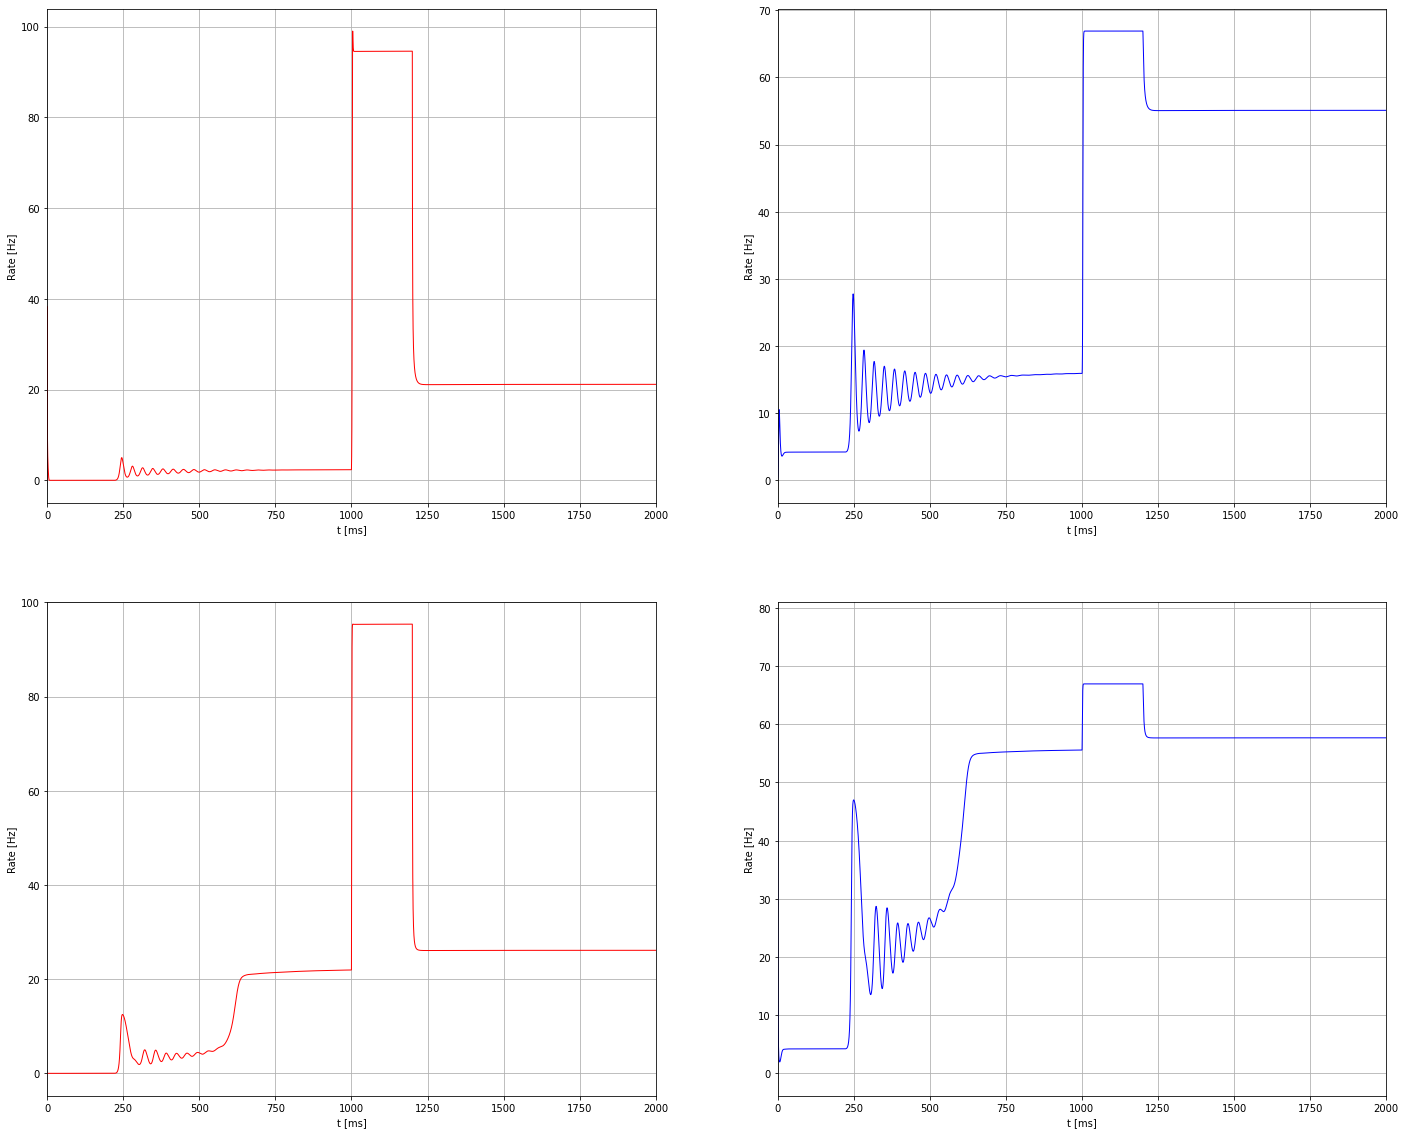

----- 4 0


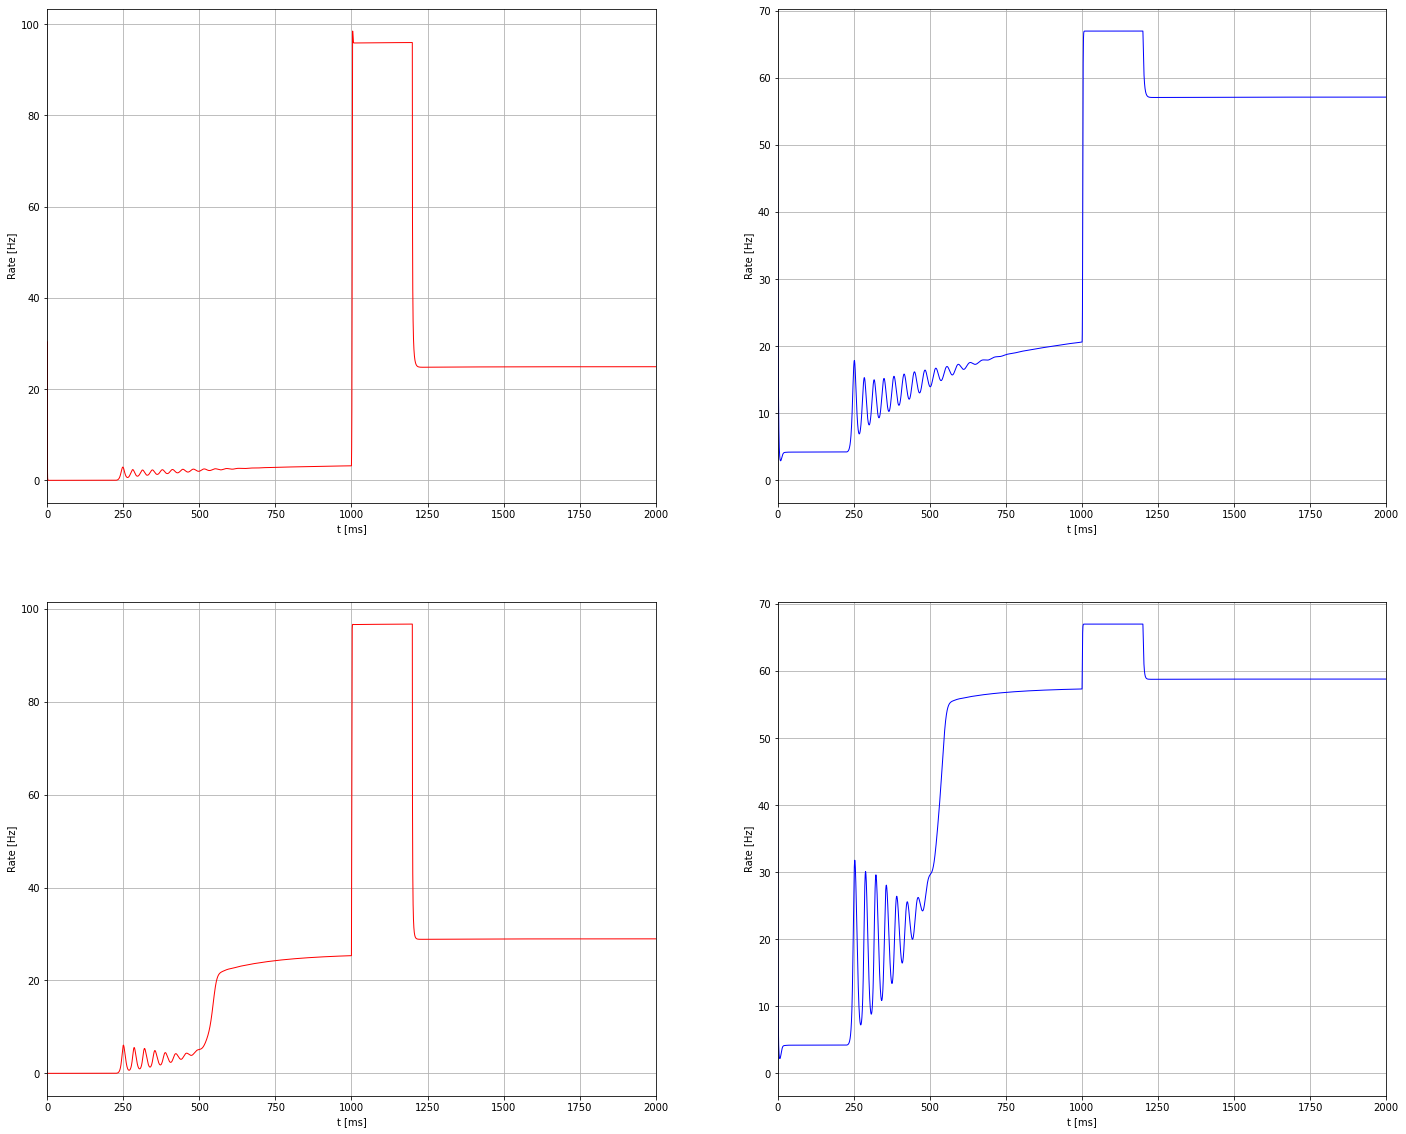

----- 5 0


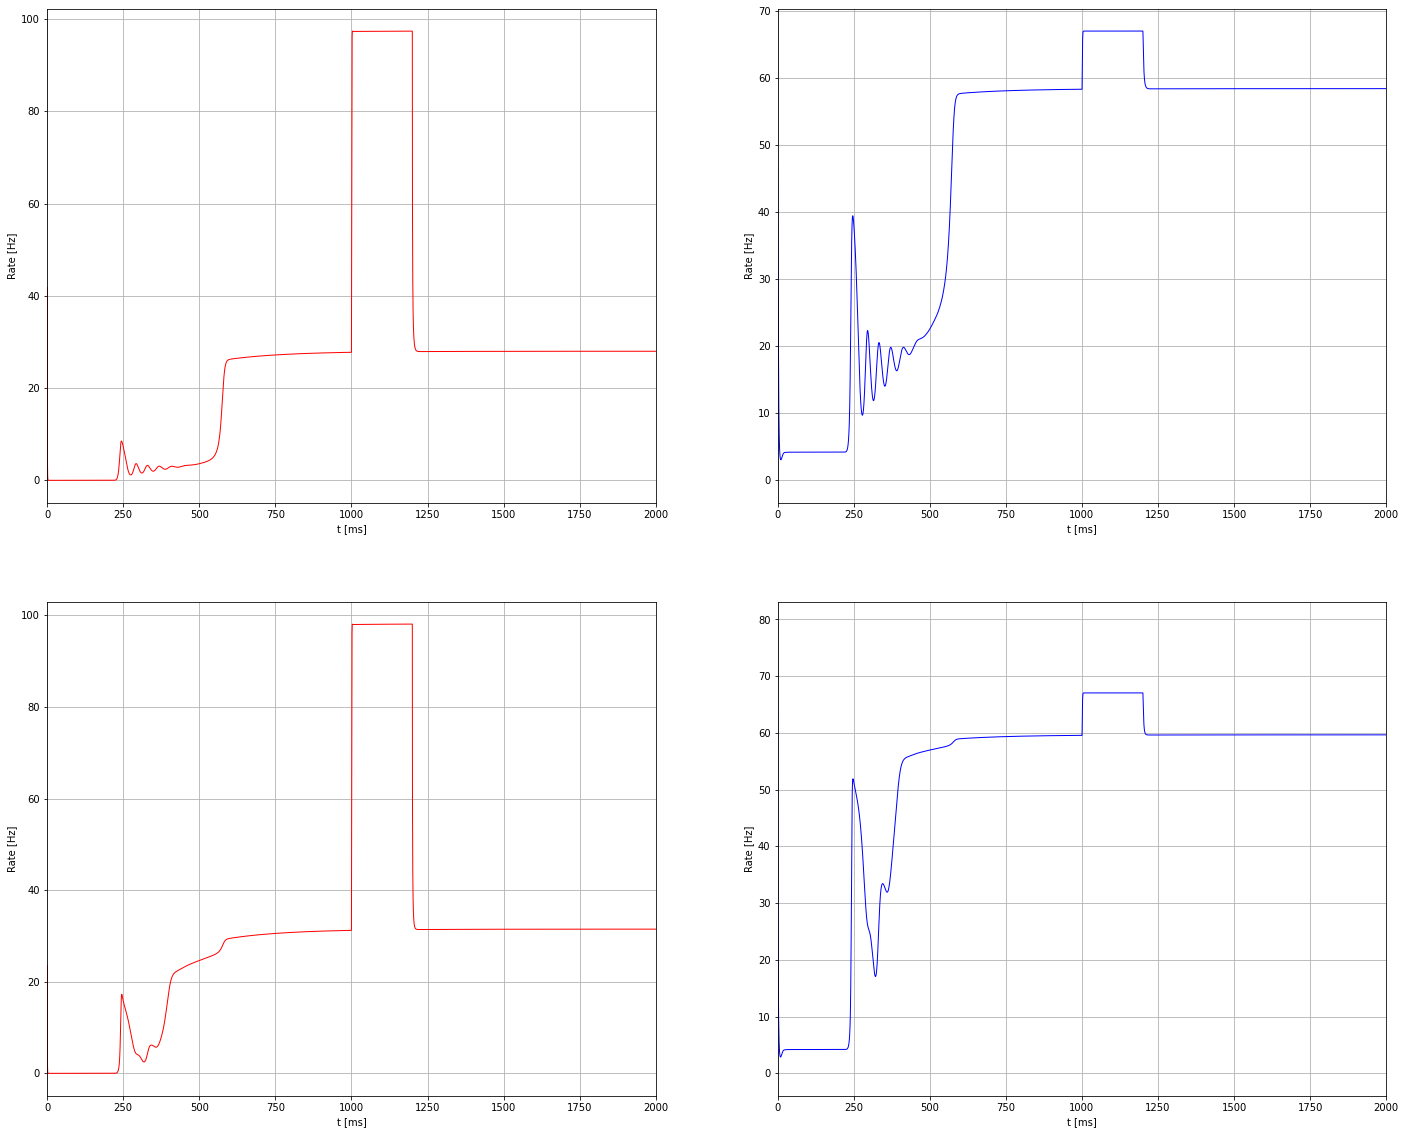

----- 6 0


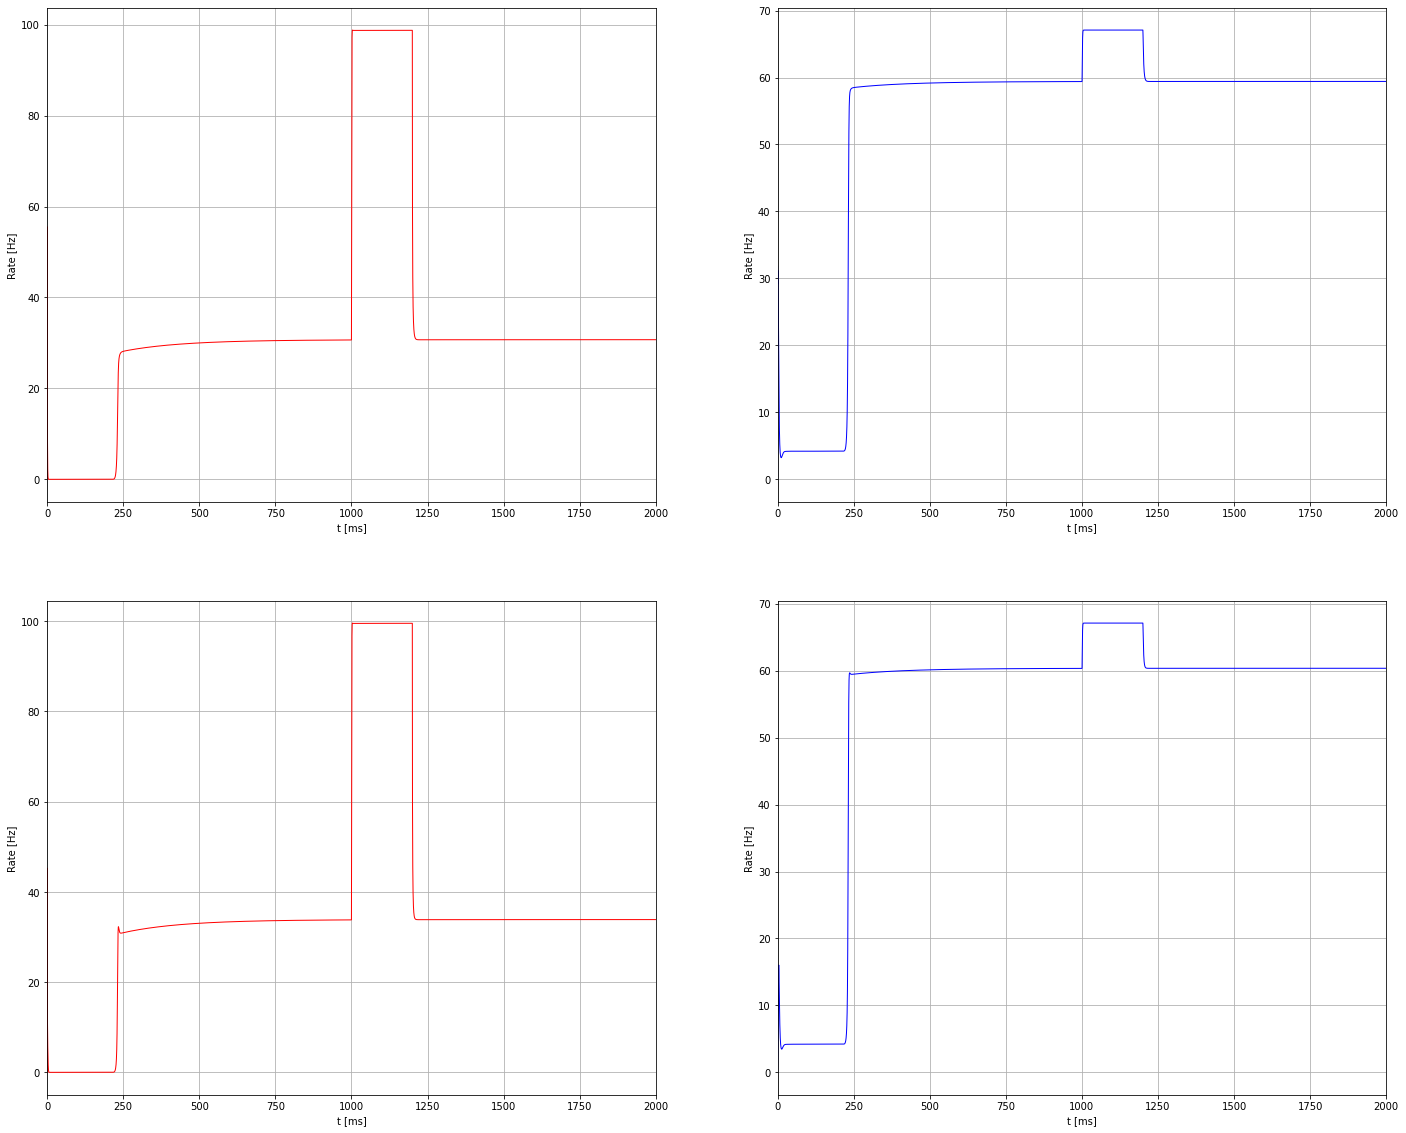

----- 7 0


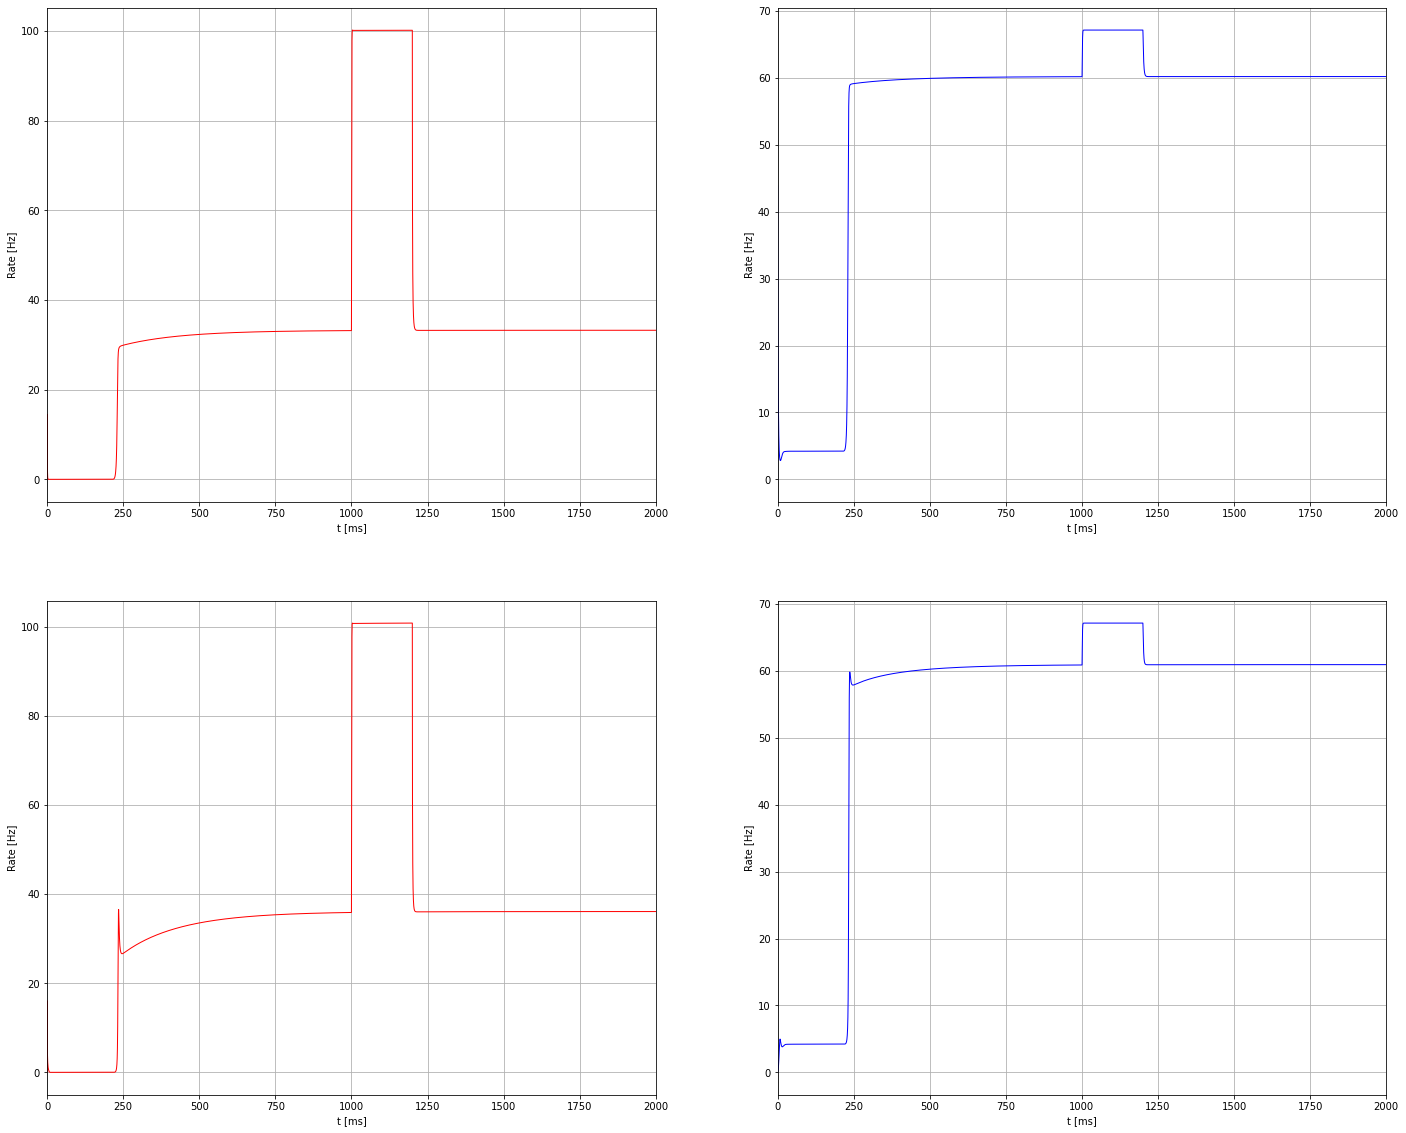

----- 8 0


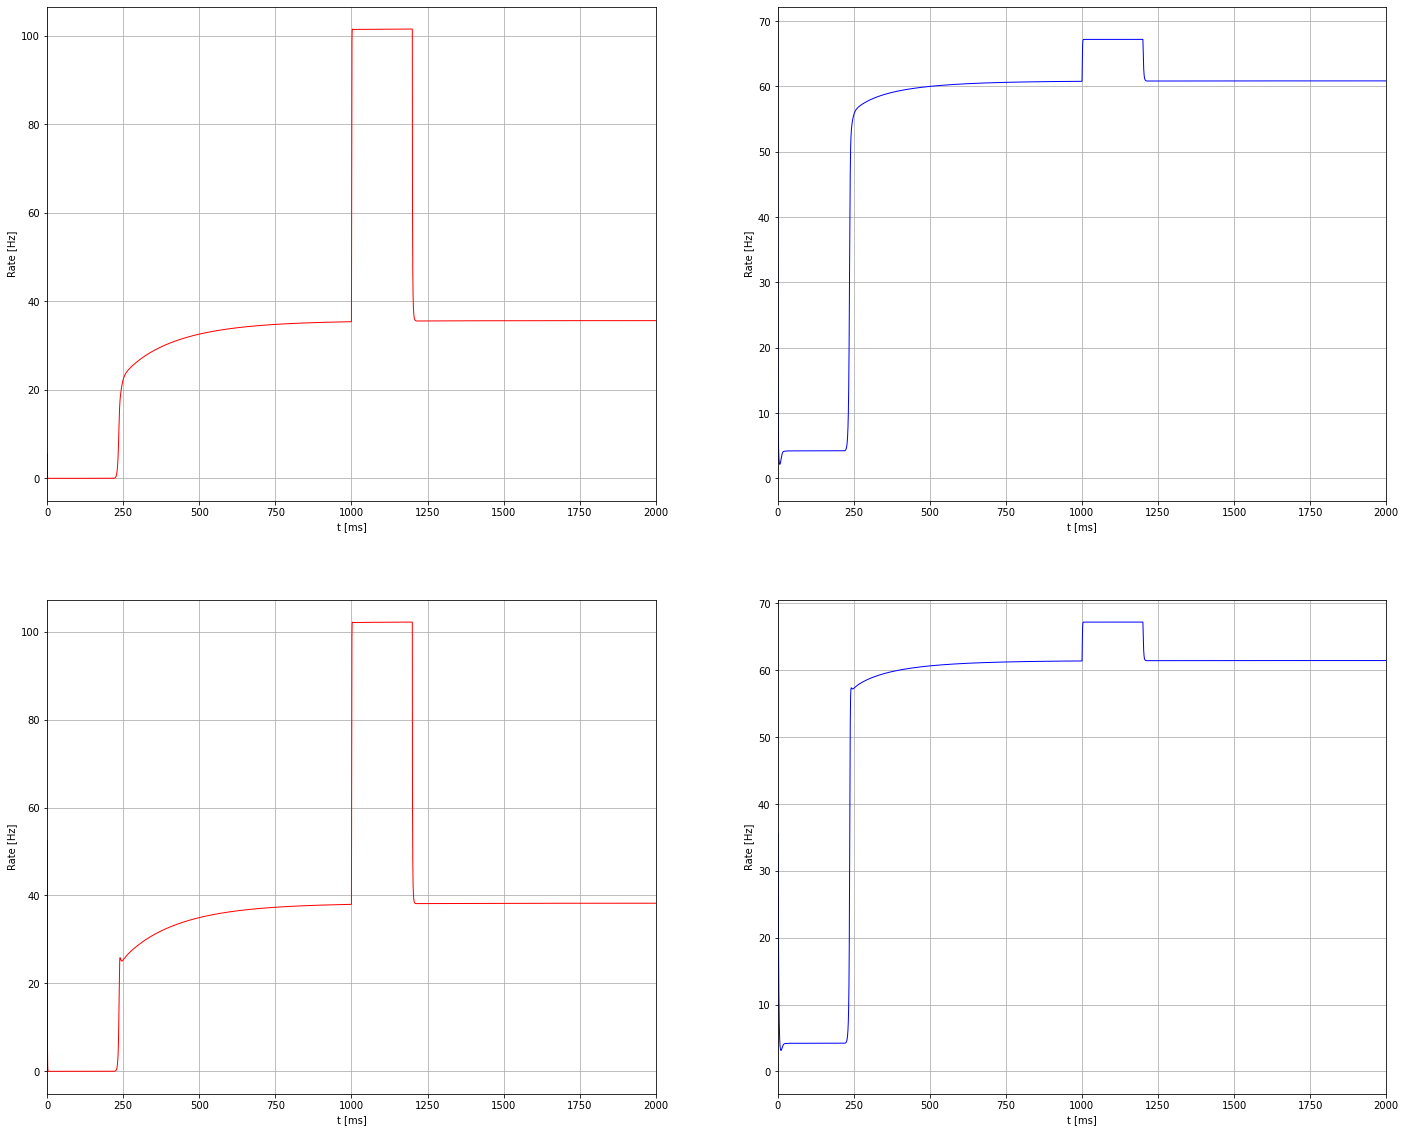

----- 0 1


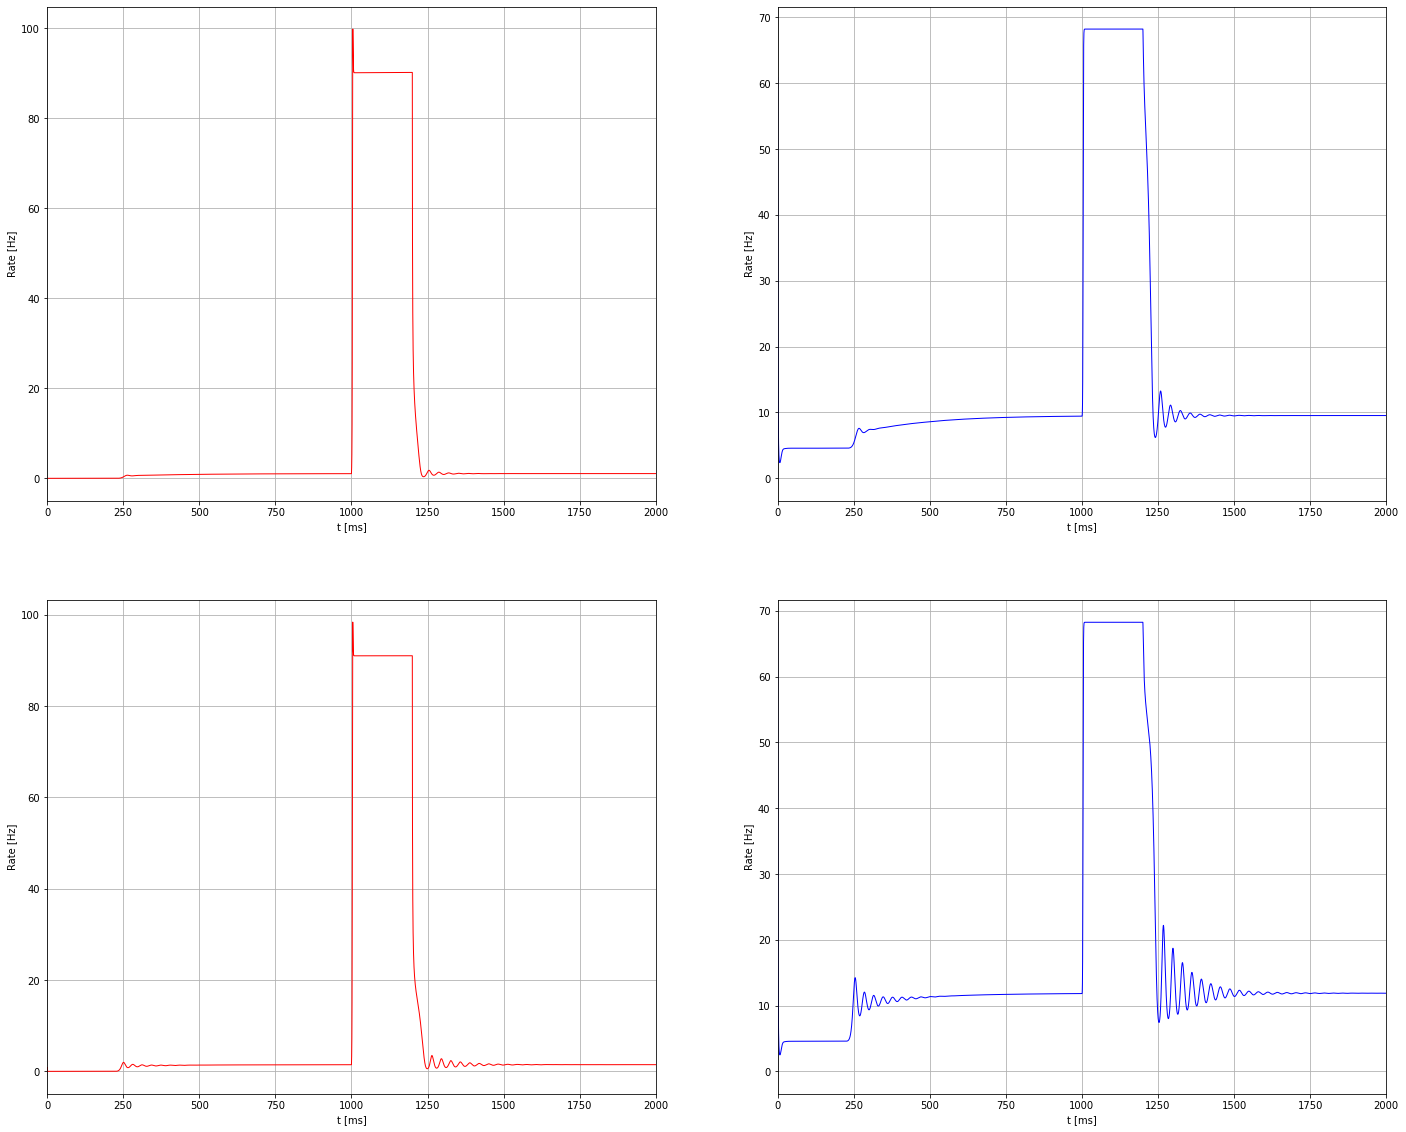

----- 1 1


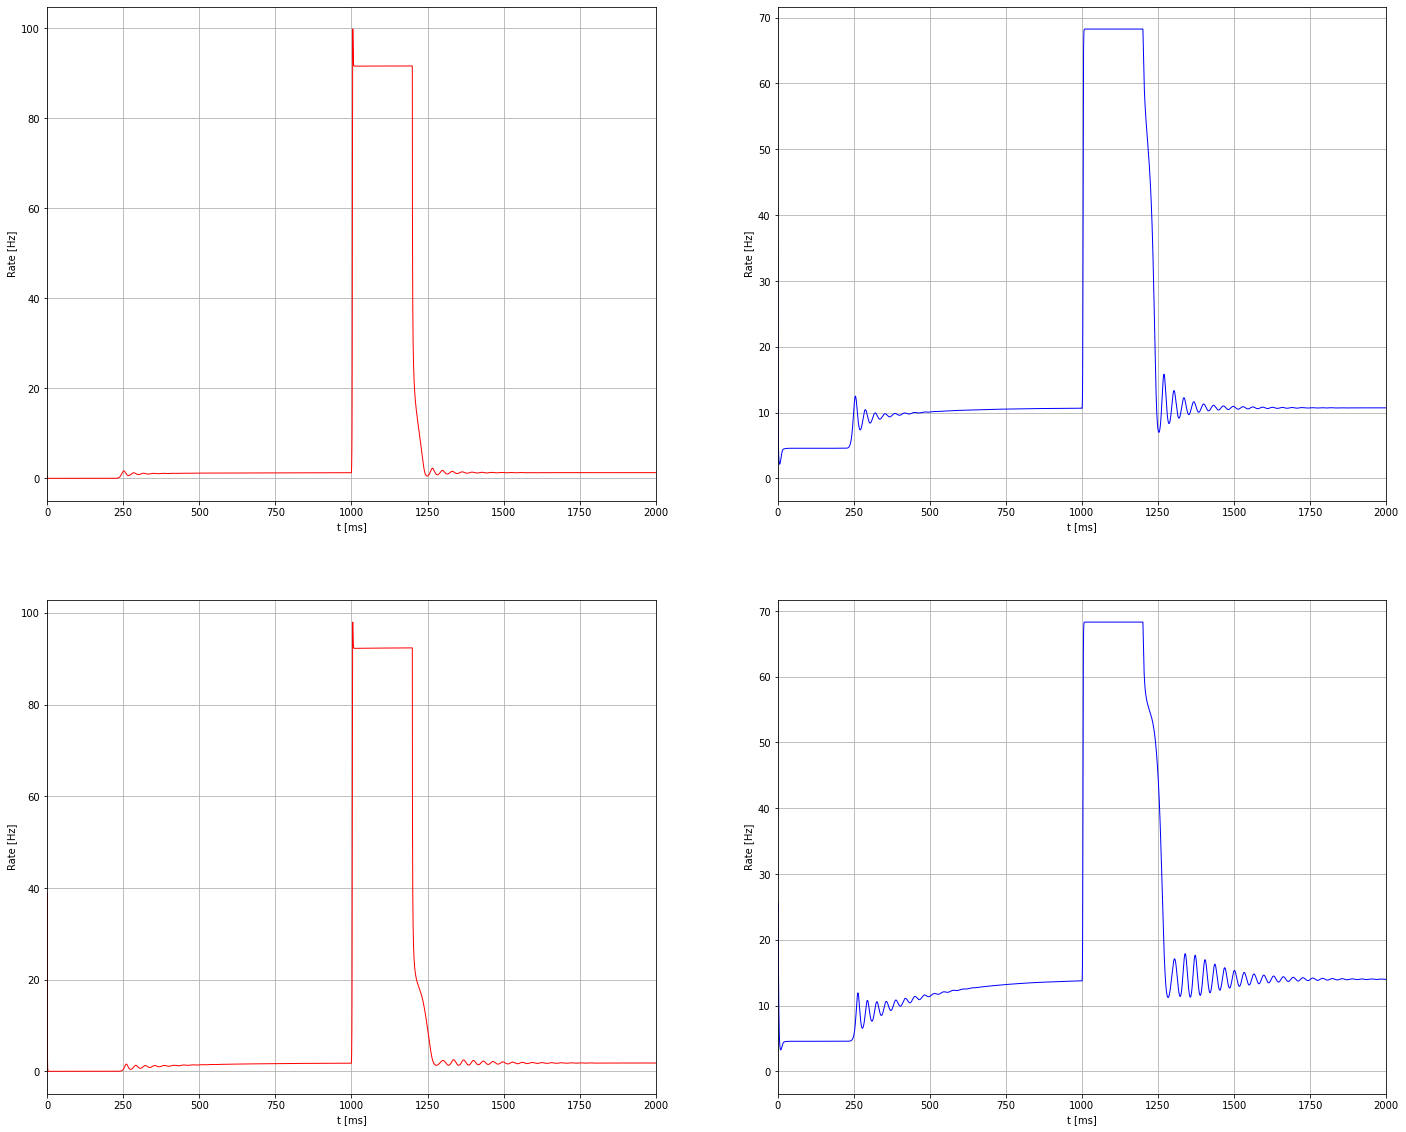

----- 2 1


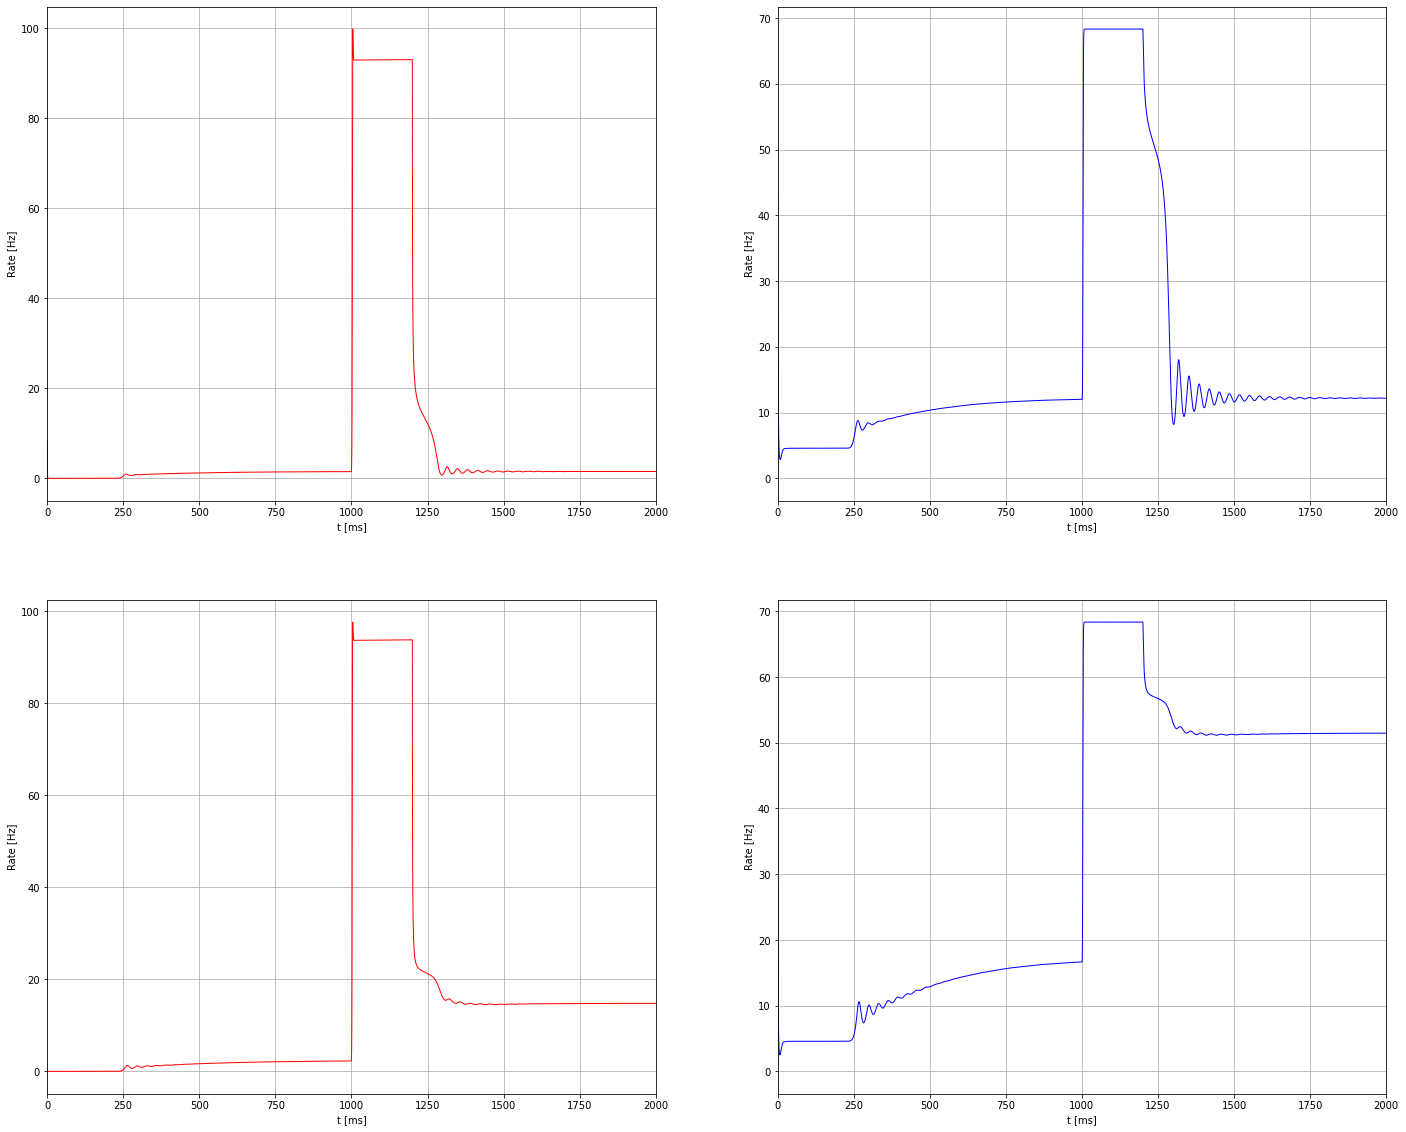

----- 3 1


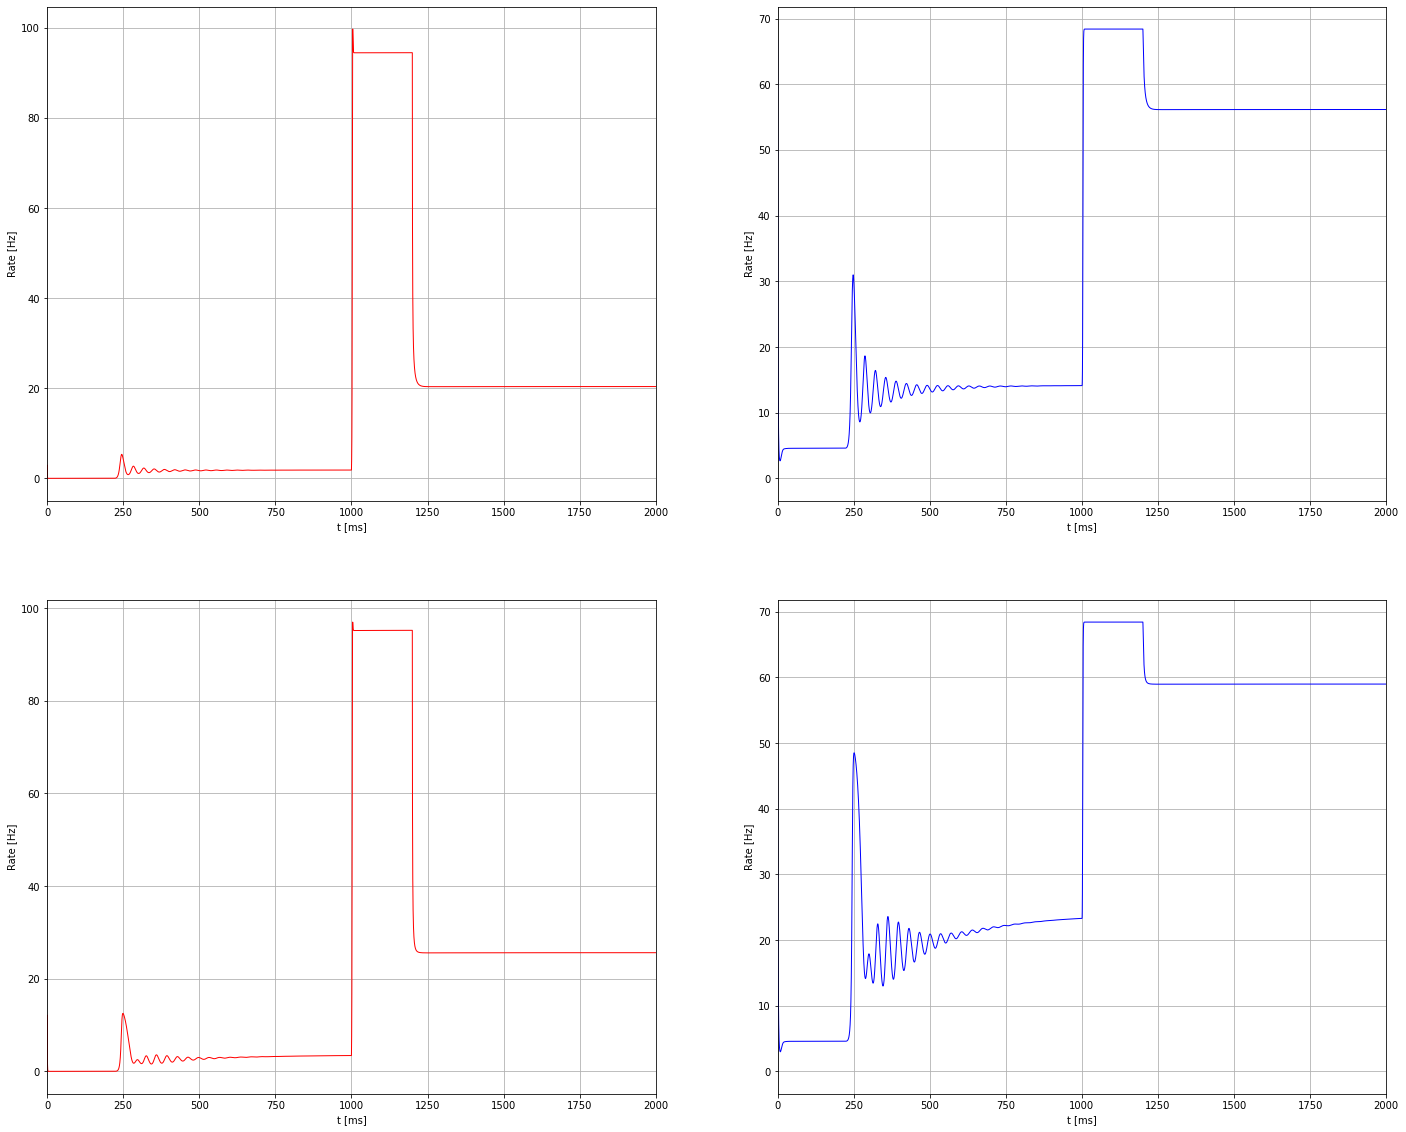

----- 4 1


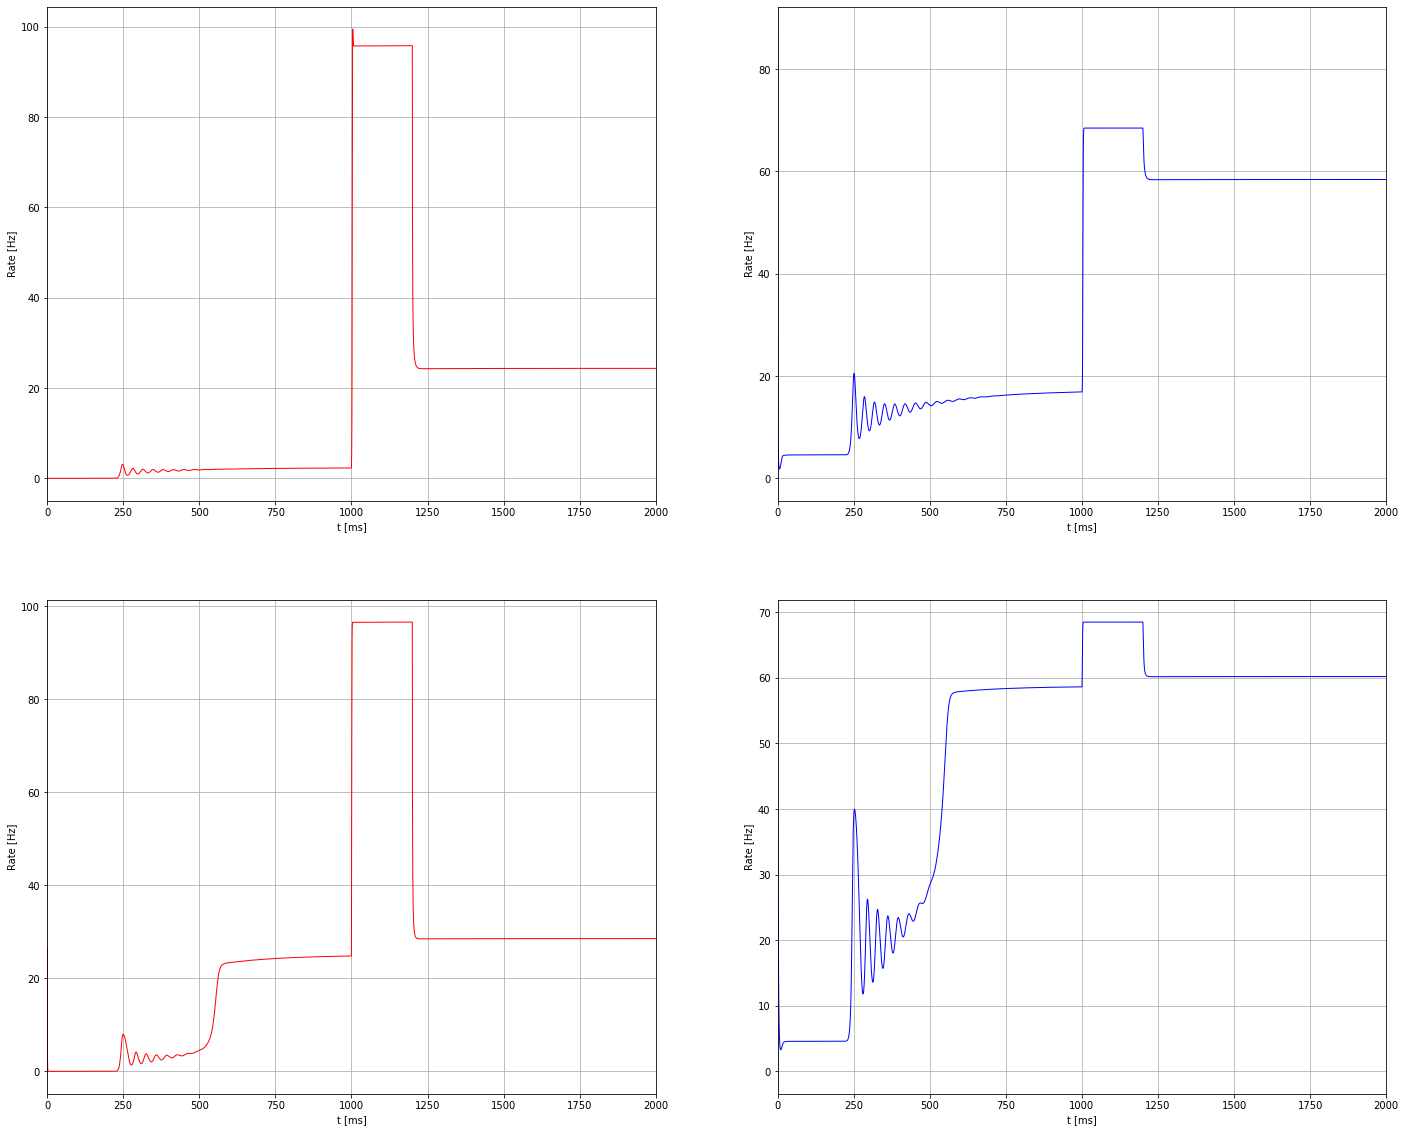

----- 5 1


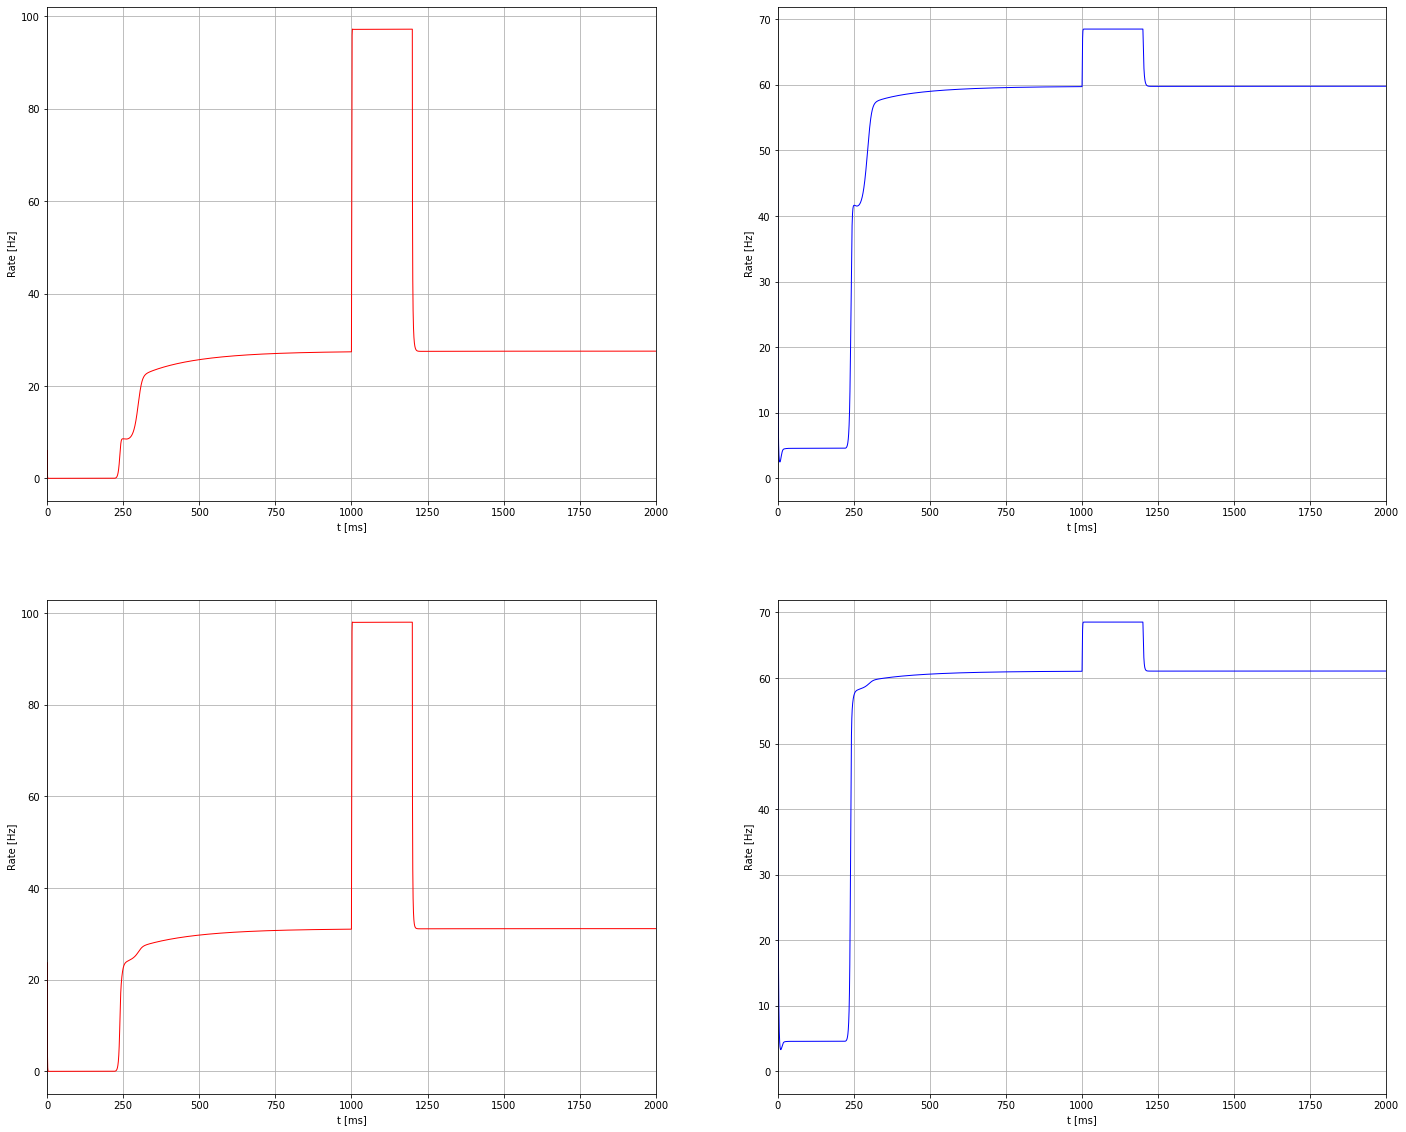

----- 6 1


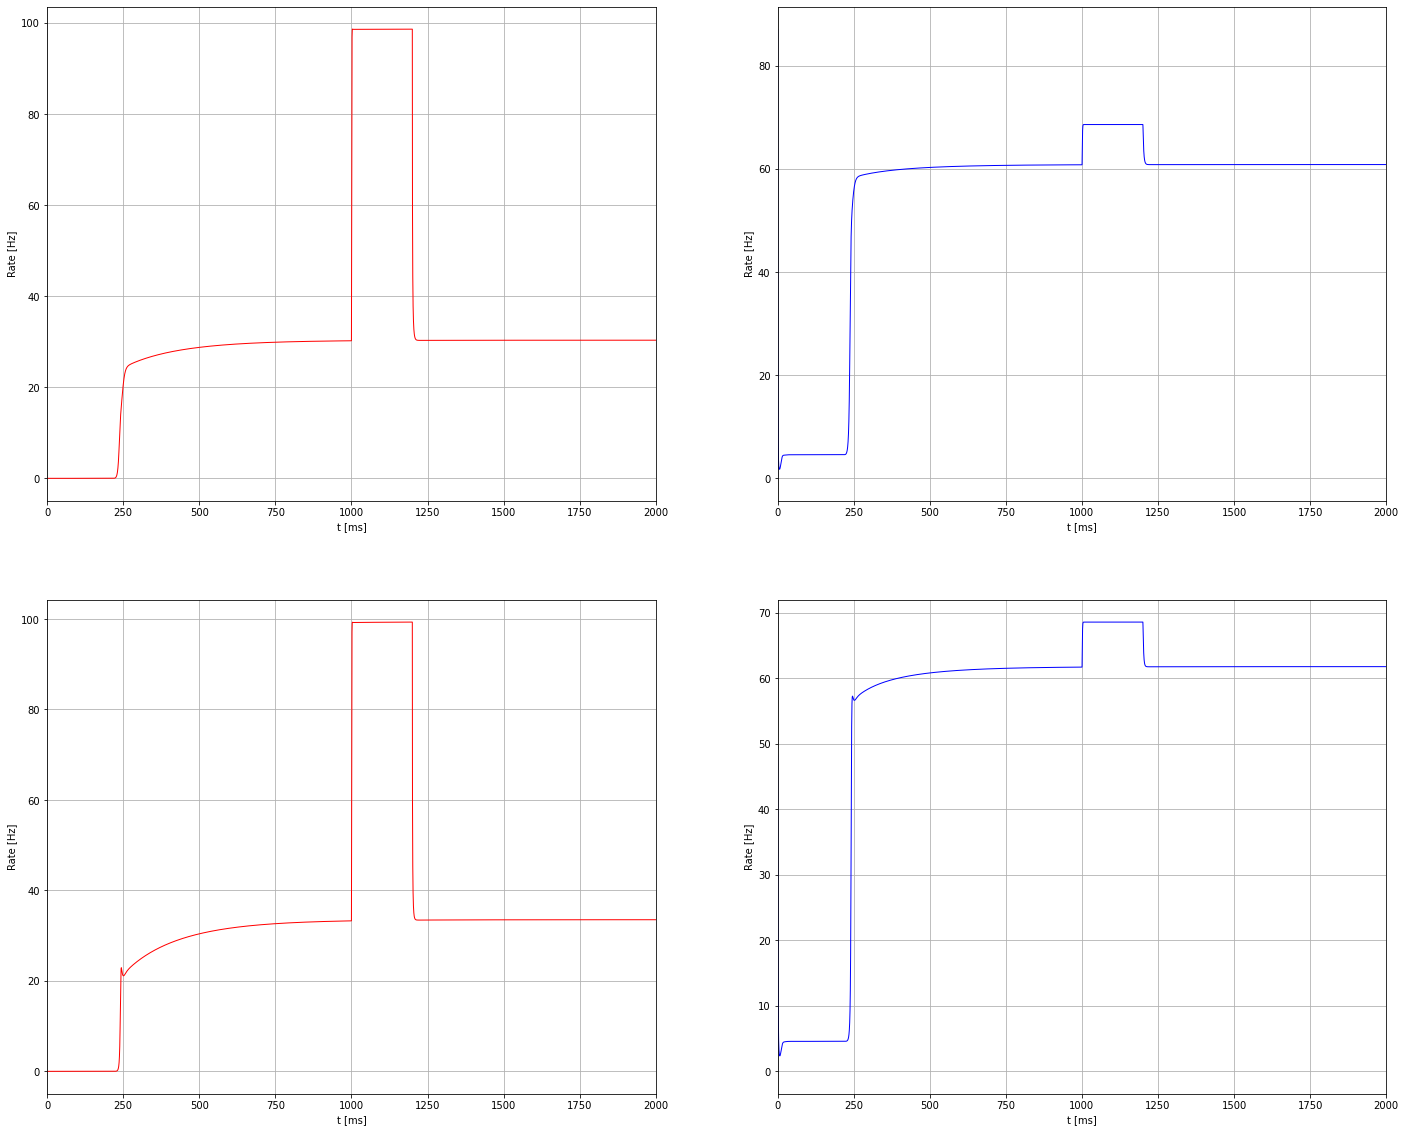

----- 7 1


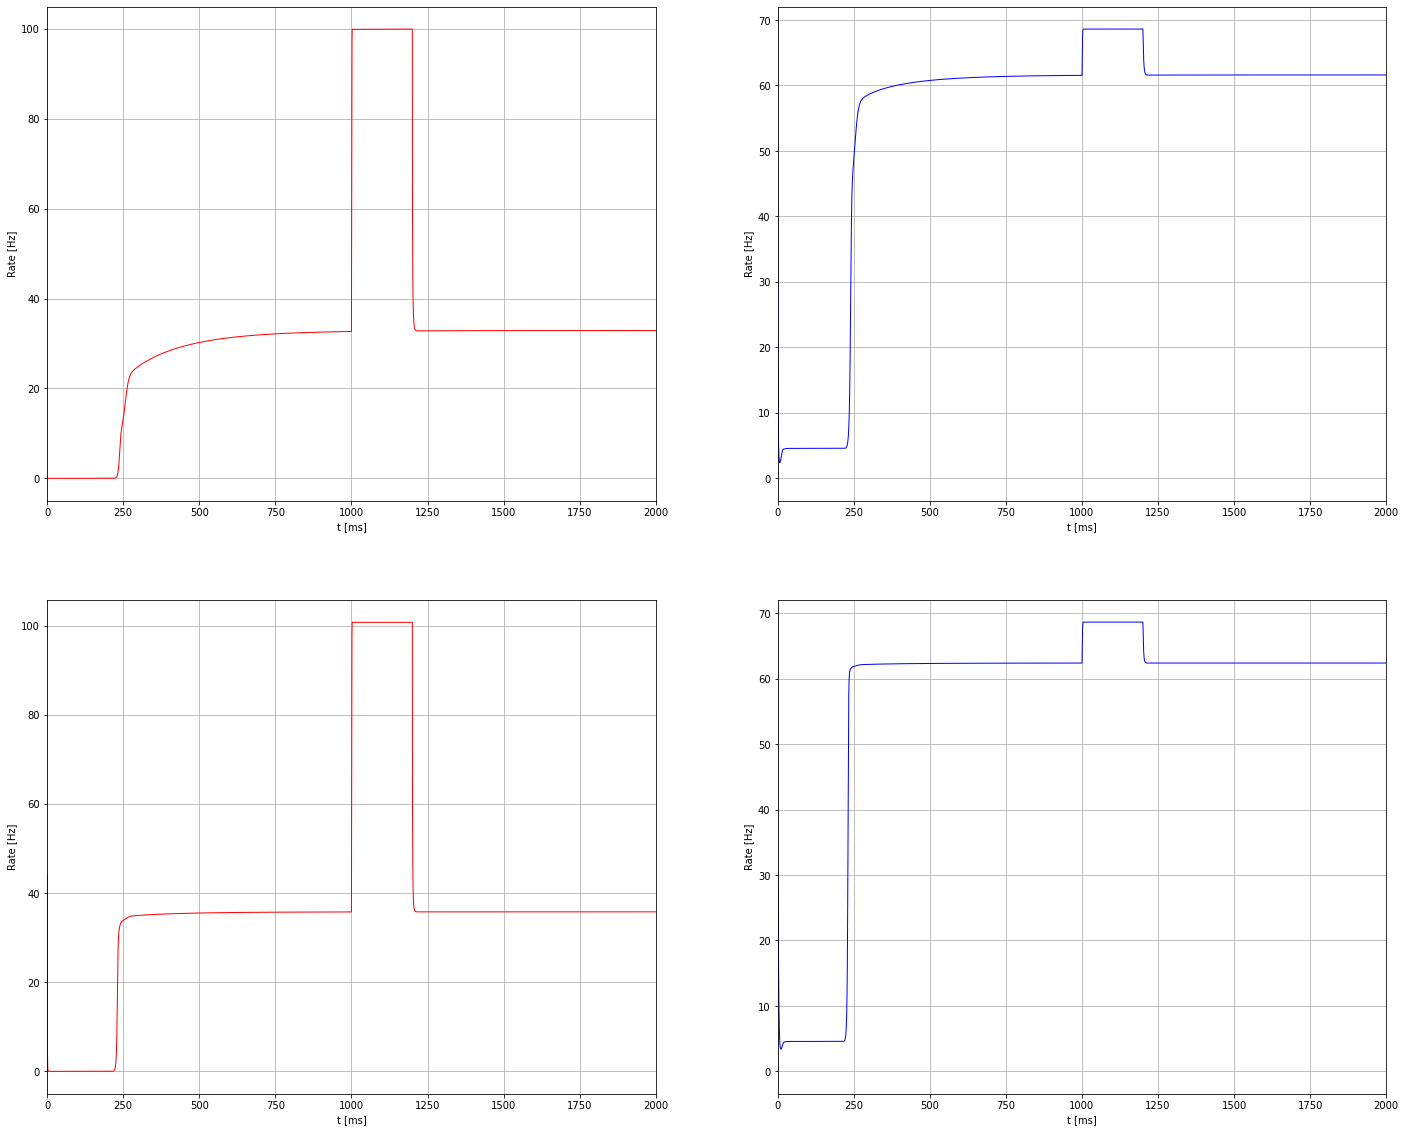

----- 8 1


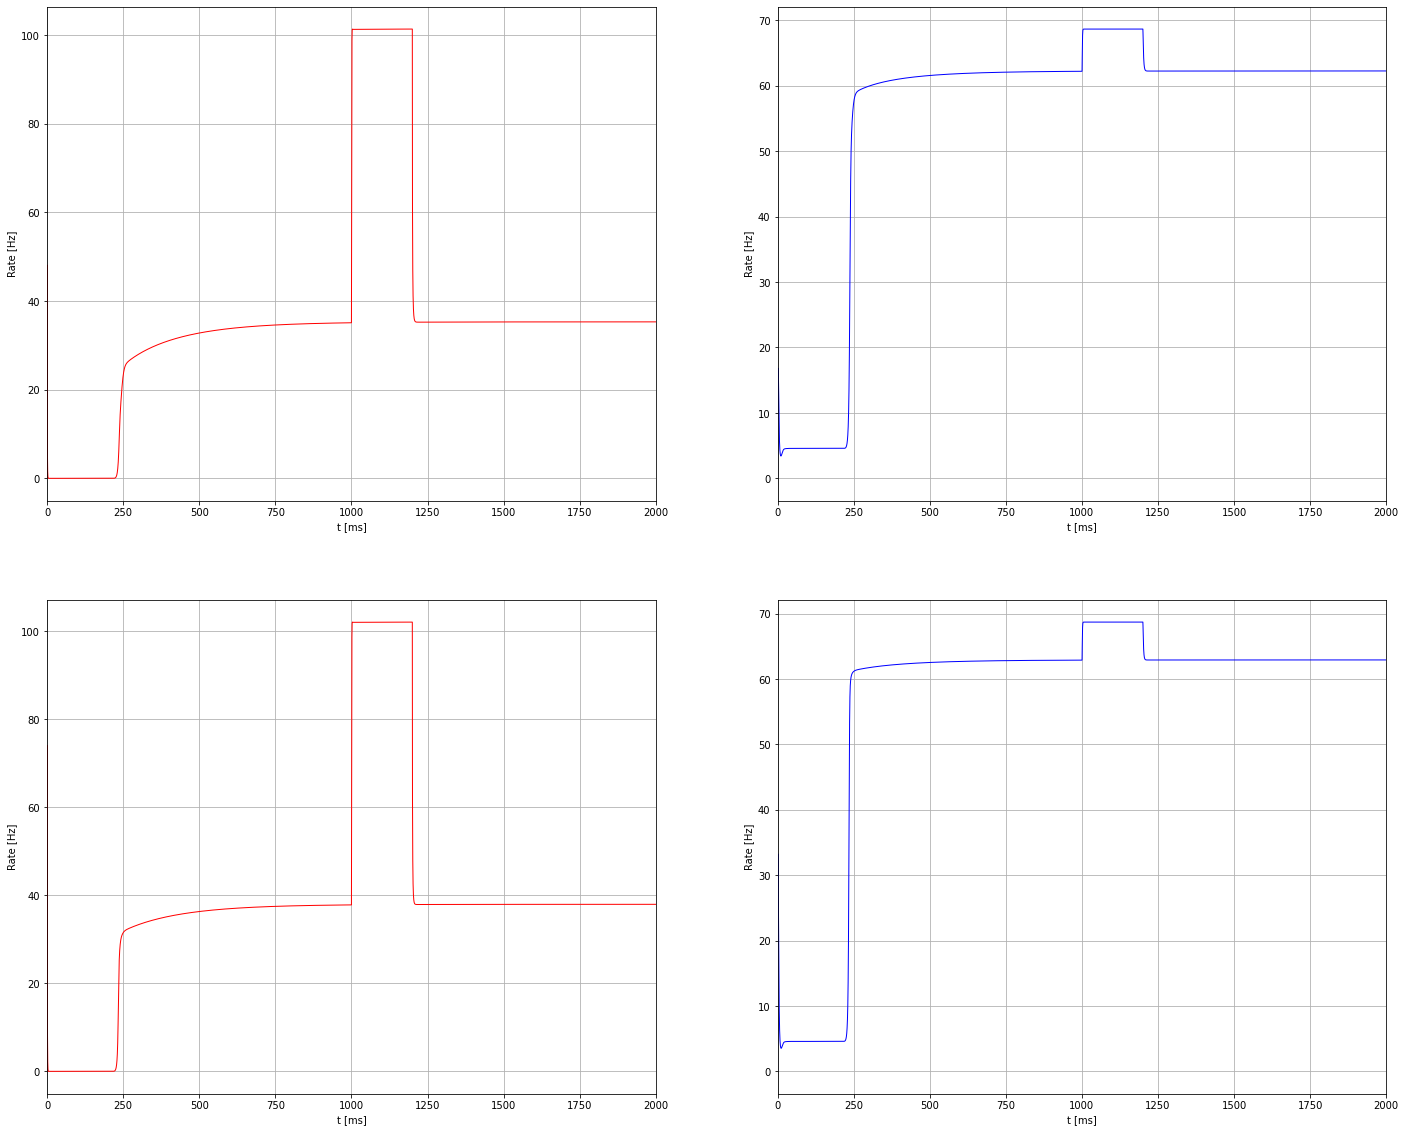

In [110]:
mu_e = np.arange(0.35,0.43,0.01)
mu_i = np.arange(0.27,0.28,0.01)
state = np.zeros (( len(mu_e), len(mu_i) ))

for i in range(len(mu_i)):
    for e in range(len(mu_e)):                
        print('-----', e, i)
        aln = initmodel(mu_e[e], mu_i[i], cmat, dmat)
        
        aln.params.duration = 2 * 1000.
        aln.params.dt = 0.1
        
        t_ = int(round( 200. / aln.params.dt, 1) )
        t1 = int( round( aln.params.duration /aln.params.dt / 2., 1) )
        t0 = int( t1 - t_ )
        
        control0 = aln.getZeroControl()
        control0[:,0,:int(2*t_)] = -2.
        control0[:,0,t1:int(t1 + 2.*t_)] = 2.
        aln.run(control=control0)
        
        plot_0()


----- 0.37 0.27


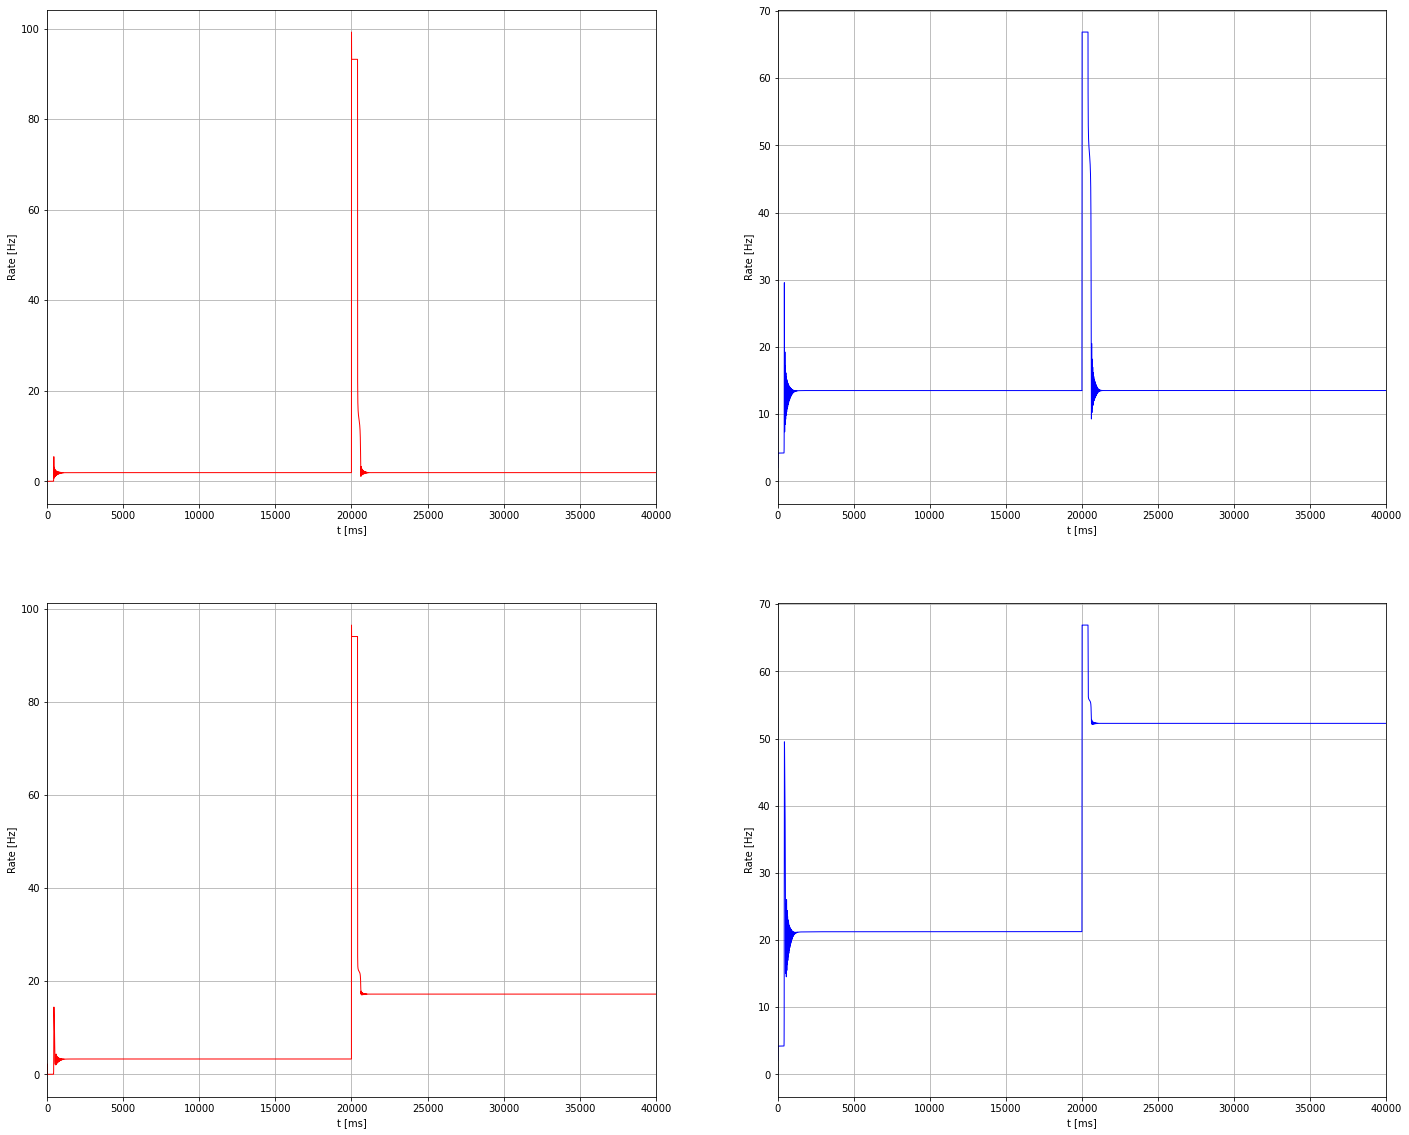

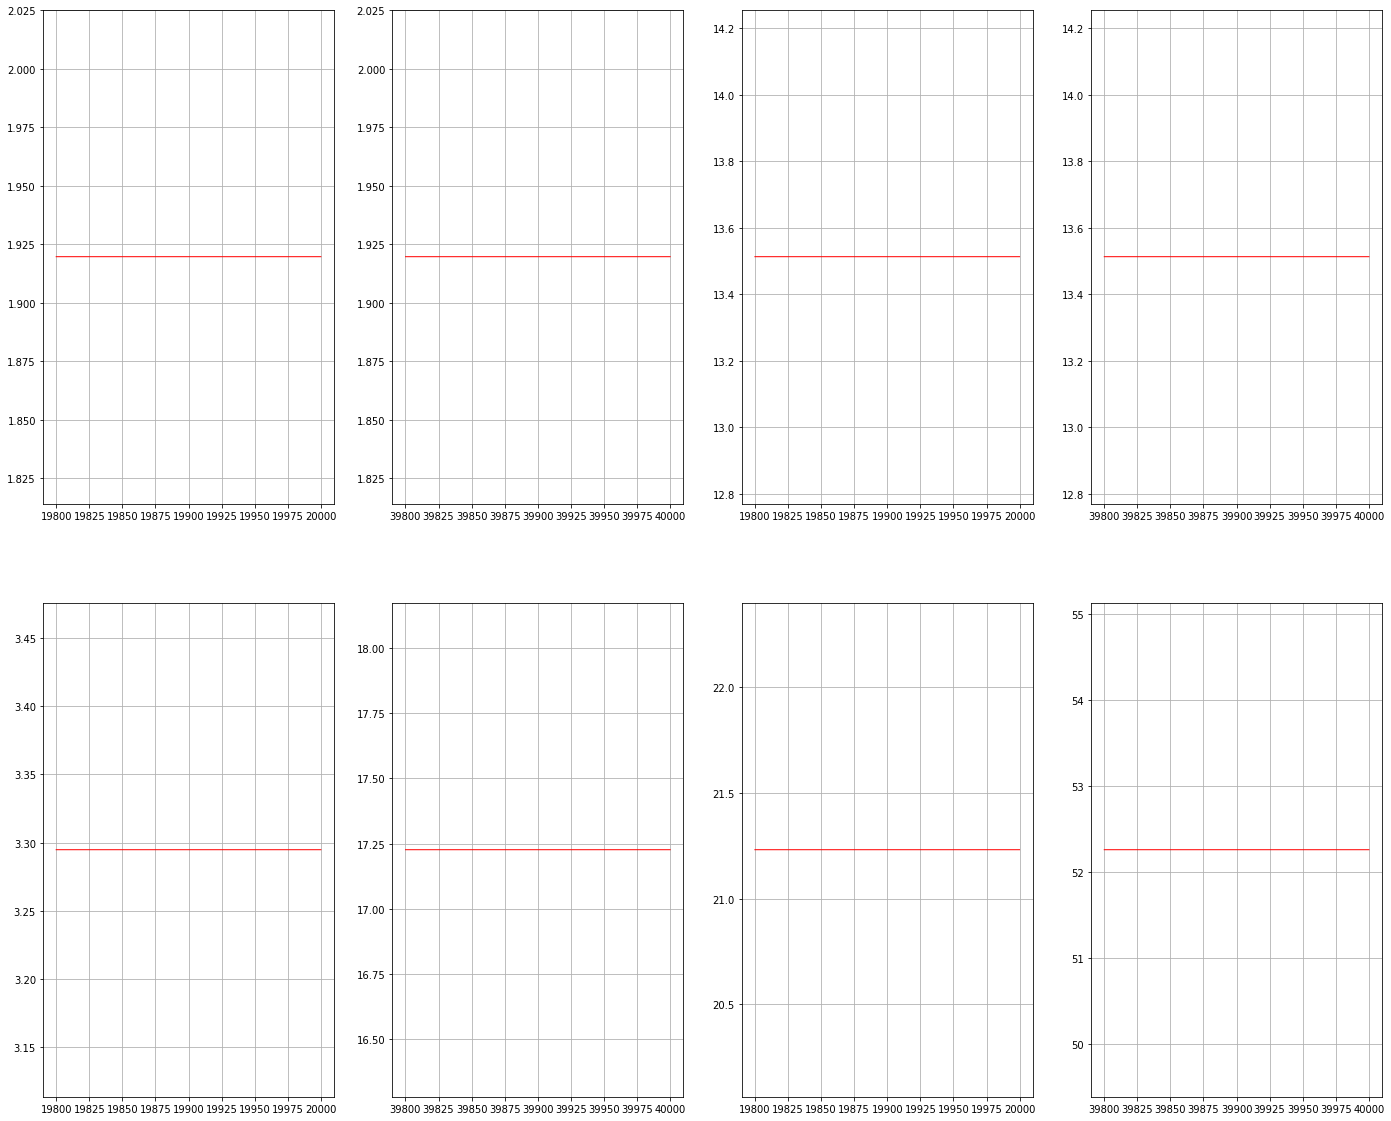

----- 0.37 0.28


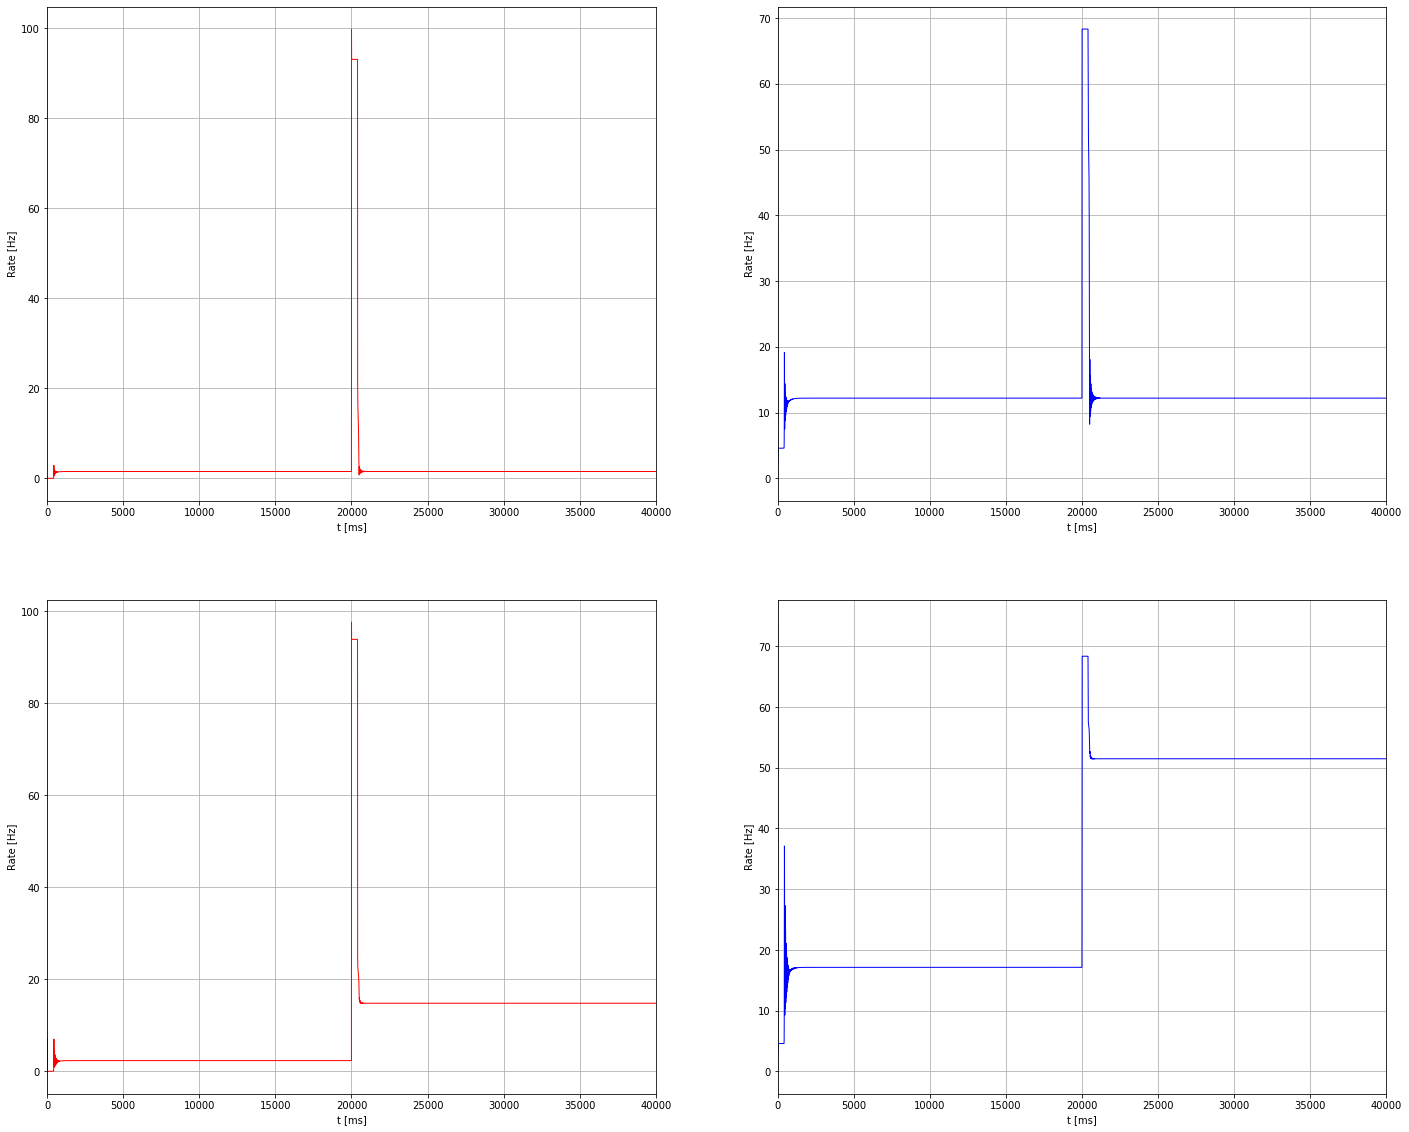

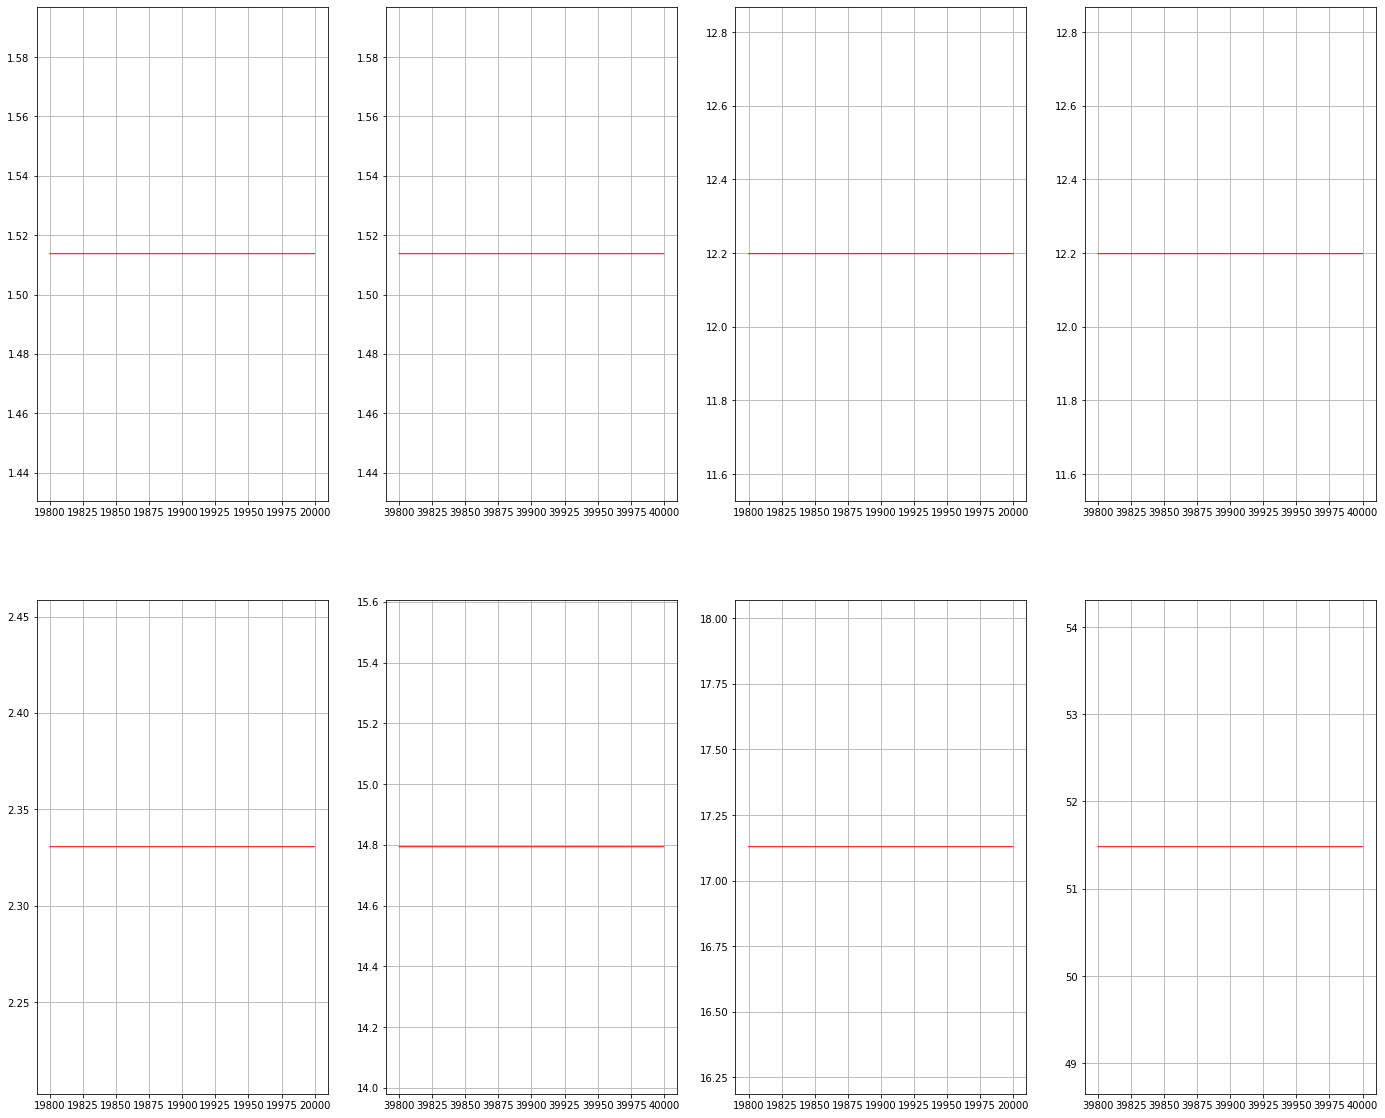

In [113]:
for [i,j] in [ [2,0], [2,1] ]:
        
        print('-----', mu_e[i], mu_i[j])
        aln = initmodel(mu_e[i], mu_i[j], cmat, dmat)

        aln.params.duration = 40 * 1000.
        aln.params.dt = 0.1
        
        t_ = int(round( 200. / aln.params.dt, 1) )
        t1 = int( round( aln.params.duration /aln.params.dt / 2., 1) )
        t0 = int( t1 - t_ )
        
        control0 = aln.getZeroControl()
        control0[:,0,:int(2*t_)] = -2.
        control0[:,0,t1:int(t1 + 2.*t_)] = 2.
        aln.run(control=control0)
        
        plot_0()
        
        fig, ax = plt.subplots(2,4, figsize=(24,20))
        ax[0,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[0,t0:int(t0+t_)], lw=1, c='red', label='Node 0 exc')
        ax[1,0].plot(aln.t[t0:int(t0+t_)], aln.rates_exc[1,t0:int(t0+t_)], lw=1, c='red', label='Node 0 exc')
        ax[0,1].plot(aln.t[-t_:], aln.rates_exc[0,-t_:], lw=1, c='red', label='Node 0 exc')
        ax[1,1].plot(aln.t[-t_:], aln.rates_exc[1,-t_:], lw=1, c='red', label='Node 0 exc')
        
        ax[0,2].plot(aln.t[t0:t0+t_], aln.rates_inh[0,t0:t0+t_], lw=1, c='red', label='Node 0 exc')
        ax[1,2].plot(aln.t[t0:t0+t_], aln.rates_inh[1,t0:t0+t_], lw=1, c='red', label='Node 0 exc')
        ax[0,3].plot(aln.t[-t_:], aln.rates_inh[0,-t_:], lw=1, c='red', label='Node 0 exc')
        ax[1,3].plot(aln.t[-t_:], aln.rates_inh[1,-t_:], lw=1, c='red', label='Node 0 exc')
        
        
        plt.show()